# Выбор локации для скважины

## Резюме исследования

**Заголовок:** Исследование нефтяных скважин в трех регионах с целью выбора скважин для разработки с учетом уровня прибыли и порогового значения риска убытка

**Описание проекта:** Компания предоставила данные с характеристиками исследованных скважин в трех регионах (в каждом - 100 тыс. месторождений) с целью их потенциальной разработки и получения наибольшей прибыли. Среди них — **объем запасов в скважине в тыс. баррелей**. Эту информацию получили по результатам геологоразведки.

**Цель исследования:** 
1. Спрогнозировать объем запасов на тестовой выборке при помощи модели линейной регрессии по скважинам каждого региона.
2. Посчитать прибыль и риск убытков по скважинам каждого из регионов.
3. Дать рекомендации по выбору региона для разработки скважин на основе данных, спрогнозированных моделью машинного обучения.

**Ход исследования:**
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, замена пропущенных значений, корректировка типов данных
* Исследовательский анализ данных: анализ количественных и категриальных признаков, корреляционный анализ признаков
* Формирование пайплайна и обучение модели регрессии (таргет - объем запасов в скважине в тыс. баррелей), оценка её качества
* Расчет средней прибыли по скважинам каждого из регионов, расчет уровня риска техникой *Bootstrap*
* Формирование рекомендаций по выбору региона для разработки скважин

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций

## Импорт библиотек

In [290]:
!pip install phik -q
!pip install shap -q
!pip install numpy==1.22 -q
!pip install matplotlib==3.5.3 -q

In [291]:
# Импортируем библиотеки для работы над проектом

import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import phik
import time
import shap

# загружаем библиотеки для проверки признаков на мультиколлениарность
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, KFold

from sklearn.inspection import permutation_importance

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer

# Загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, accuracy_score, confusion_matrix

from sklearn.dummy import DummyRegressor

from typing import Union, List, Dict

from numpy.random import RandomState

# Импорт метода для проверки нормальности распределения
from scipy.stats import shapiro, mannwhitneyu, normaltest

from scipy import stats as st

# Задаём настройки для разделения выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (12, 8);

# Настройка отображения
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)        # Ширина отображения
pd.set_option('display.max_colwidth', None)   # Максимальная ширина столбца
pd.set_option('display.float_format', '{:.2f}'.format)  # Формат чисел

## Классы и функции

### Классы для обработки датасета

In [292]:
# Создадим классы для работы с датасетами и колонками

# Класс (датафрейм)
class Data:
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Данные должны быть типа pd.DataFrame')
        
        self.data = data
        self.X_train = None
        self.X_test_transformed = None
        self.y_train = None
        self.y_test = None
        
        self.selected_features = list(self.data.columns)
        
    def show_info(self): # Функция для анализа общей информации по датасету
        self.data.info()

    def print_head(self, n: int = 5): # Функция для ознакомления с данными
        if not isinstance(n, int) or n <= 0:
            raise ValueError('Параметр n должен быть положительным целым числом больше нуля')
        return self.data.head(n)

    def unify_columns(self, df: pd.DataFrame): # Функция для перевода имён столбцов по словарю
        new_cols = {}
        for eng_key, ru_names in dict_column_translations.items():
            for ru_name in ru_names:
                if ru_name in df.columns:
                    new_cols[ru_name] = eng_key
                    break
        df.rename(columns=new_cols, inplace=True)
    
    def get_numeric_columns(self) -> list: # Функция для получения списка столбцов с числовыми данными
        return self.data.select_dtypes(include=['number']).columns.tolist()
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 1.0]): # Функция для ознакомления с количественными показателями
        numeric_columns = self.get_numeric_columns()
        return self.data[numeric_columns].describe(percentiles=percentiles)
    
    def count_duplicates(self): # Функция для подсчета явных дубликатов
        return self.data.duplicated().sum()
    
    def get_duplicate_rows(self): # Функция для вывода явных дубликатов
        self.data[self.data.duplicated(keep=False)]
    
    def get_string_columns(self): # Возвращает список строковых столбцов
        string_columns = self.data.select_dtypes(include=['object', 'string']).columns
        if string_columns.empty:
            print('Строковых столбцов нет')
            return []
        else:
            return string_columns
    
    def show_unique_vals_string_columns(self, column_name: Union[str, list[str], None] = None): # Выводит уникальные значения в строковых столбцах
        max_display = 30
        if column_name is None:
            columns = self.get_string_columns()
        elif isinstance(column_name, str):
            columns = [column_name]
        else:
            columns = column_name
            
        for col in columns:
            unique_values = sorted(self.data[col].dropna().unique())
            print(f'Уникальные значения для столбца: {col}')
            print(f'Количество уникальных значений: {len(unique_values)}')
            if len(unique_values) <= max_display:
                print(unique_values)
                print('-' * 30)
            else:
                print(unique_values[:max_display])
                print('-' * 30)
                
    def drop_duplicate_rows(self): # Функция для удаления явных дубликатов
        self.data.drop_duplicates(keep='first', inplace=True)
        return self.data

    def count_missing_values(self): # Функция для подсчета строк с пропущенными значениями
        return self.data.isna().sum()
    
    def drop_na(self, column_name: str): # Функция для удаления строк с пропущенными значениями
        self.data.dropna(subset=[column_name], inplace=True)
        return self.data
    
    def count_rows(self): # Функция для подсчета строк
        return len(self.data)
    
    def to_lowercase_columns(self): # Фунция для приведения имен столбцов в нижний регистр
        self.data.columns = self.data.columns.str.lower()
        print(self.data.columns)
    
    def replace_multiple_column_name(self, replacements: dict): # Функция для множественной замены символов в названиях столбцов
        def replace_chars(value):
            for old, new in replacements.items():
                value = value.replace(old, new)
            return value
        
        self.data.columns = self.data.columns.map(replace_chars)
        print(self.data.columns)
        
    def process_string_columns(self, columns, replacements=dict, lowercase_list=None):
        for col in columns:
            col_obj = Column(self.data, col)
            
            if lowercase_list and col in lowercase_list:
                col_obj.to_lowercase_rows()
                
            if replacements:
                col_obj.replace_strings(replacements)
                
            self.show_unique_vals_string_columns(column_name=col)
    
    def convert_columns_to_float(self, column_names: list[str], replacements: Union[Dict, None] = None): # Функция для замены типа данных на 'float'
        for col in column_names:
            if col in self.data.columns:
                col_obj = Column(self.data, col)
                if replacements:
                    col_obj.replace_strings(replacements)
                col_obj.change_type('float')
                print(f'Тип данных для столбца {col} изменен на {col_obj.get_type()}')
                
    def modify_data(self, index: str, columns: str, values: str, column_rename: Dict, column_order: List):
        '''Функция для трансформации датасета с выделением периодов в отдельные столбцы'''
        transformed_data = (self.data.pivot(index=index, columns=columns, values=values)\
              .reset_index()\
              .rename(columns=column_rename)\
              .rename_axis(None, axis=1)
             )\
        .copy()

        # Определяем желаемый порядок столбцов
        transformed_data = transformed_data[column_order]

        # Создаем новый экземпляр класса Data()
        new_data = Data(transformed_data)
        
        # Можно сохранить оригинальное имя с суффиксом
        new_data.name = f'{self.name}' if hasattr(self, 'name') else 'modified_dataset'

        # Возвращаем результат
        return new_data

    
    # Подготовка данных для тестирование модели, оценка качества модели
    
    def split(self, target_column: str, random_state=42, stratify=None): # Функция для разделения выборки на тренировочную и тестовую
        if target_column not in self.data.columns:
            raise ValueError(f"Целевая колонка '{target_column}' отсутствует в данных")
        
        X = self.data.drop(columns=target_column)
        y = self.data[target_column]
        
        stratify_param = y if stratify else None
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, random_state=random_state, stratify=stratify_param
        )
        
        print(f'Разделение завершено: обучающая выборка - {self.X_train.shape}, тестовая - {self.X_test.shape}')

        
    def select_features(self, features: list[str]): # Функция для отбора фичей
        # Проверяем, все ли запрошенные признаки есть в исходных данных
        missing = [f for f in features if f not in self.data.columns]
        if missing:
              raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        # Отбираем только нужные признаки
        self.selected_features = features
        print(f'Выбраны следующие признаки: {features}')
        
    def reset_features(self):
        self.selected_features = list(self.data.columns)
        print('Сброшен выбор признаков — используются все признаки.')
        
    def count_linear_regression_metrics(self, y_true_list: list, y_pred_list: list, model_names: list[str]) -> pd.DataFrame: # Функция для подсчета метрик линейной регресии
        if not (len(y_true_list) == len(y_pred_list) == len(model_names)):
            raise ValueError('Все входные списки должны быть одинаковой длины.')

        results = []

        for y_true, y_pred, name in zip(y_true_list, y_pred_list, model_names):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            results.append({
                'Model': name,
                'MSE': round(mse, 2),
                'RMSE': round(rmse, 2),
                'MAE': round(mae, 2),
                'R2': round(r2, 2)
            })

        return pd.DataFrame(results)

    
    def count_logistic_regression_metrics(self, y_true: np.array, y_pred: np.array): # Функция для подсчета метрик логистической регресии
    
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
    
        results = {
            'accuracy': round(accuracy, 2),
            'recall': round(recall, 2),
            'precision': round(precision, 2)
        }

        return pd.DataFrame([results])


    def threshold_table(self, y_true: np.array, y_proba): # Функция для вывода таблицы метрик Precision, Recall при разных порогах
        
        thresholds = np.arange(0.0, 1.0, 0.02)  # от 0 до 1 с шагом 0.02
        rows = []
    
        total_class_1 = (y_true == 1).sum()  # сколько всего объектов класса 1
    
        for thr in thresholds:
            y_pred = (y_proba >= thr).astype(int)  # применяем порог
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            predicted_count = y_pred.sum()
            accuracy = accuracy_score(y_true, y_pred)

            # Считаем False Positive и False Negative
            fp = ((y_pred == 1) & (y_true == 0)).sum()
            fn = ((y_pred == 0) & (y_true == 1)).sum()
    
            rows.append({
                'Порог': round(thr, 2),
                'Recall': round(recall, 3),
                'Precision': round(precision, 3),
                'Accuracy':accuracy,
                'Количество False Positive':fp,
                'Количество False Negative':fn,
                'Число предсказанных объектов': predicted_count,
                'Всего объектов класса 1': total_class_1
            })

        return pd.DataFrame(rows)

### Классы для обработки столбцов

In [293]:
# Класс (столбец датафрейма)
class Column():
    def __init__(self, data: pd.DataFrame, column_name: str):
        self.data = data
        self.column_name = column_name
        self.series = data[column_name]
        
        if column_name not in self.data.columns:
            raise KeyError(f'Столбец "{column_name}" не найден в датафрейме')
    
    def describe_numeric(self): # Функция для ознакомления с количественными показателями
        return self.series.describe()
    
    def count_values(self): # Функция для вывода и подсчета уникальных значений
        return self.series.value_counts()
    
    def fill_na(self, new_value): # Функция для заполнения пропущенных значений
        self.data[self.column_name].fillna(new_value, inplace=True)
        self.series = self.data[self.column_name]
        return self.series
    
    def replace_strings(self, replacements):
        for old, new in replacements.items():
            self.data[self.column_name] = self.data[self.column_name].str.replace(old, new, regex=False)
            self.series = self.data[self.column_name]
        return self.series
    
    def change_type(self, new_type): # Функция для изменения типов данных
        self.data[self.column_name] = self.data[self.column_name].astype(new_type)
        self.series = self.data[self.column_name]
        return self.series
    
    def get_type(self): # Функция для выводы типа данных
        return self.series.dtype
    
    def to_lowercase_rows(self): # Фунция для приведения значений в нижний регистр
        self.data[self.column_name] = self.data[self.column_name].str.lower()
        self.series = self.data[self.column_name]
        return self.series
    
    def print_unique(self): # Функция для отображения уникальных значений в колонке
        return self.series.unique()

### Классы для обработки групп датасетов

In [294]:
# Создадим класс для работы с группой датасетов

class DatasetManager:
    def __init__(self, datasets: dict[str, Data]):
        self.datasets = datasets
        
    def show_info_all(self): # Выводит общую информацию о каждом датасете
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.show_info()
            print('-' * 30)
            print()
            
    def print_head_all(self, n = 5): # Выводит заданное количество строк в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.print_head(n))
            print('-' * 30)
            
    def describe_numeric_all(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Выводит описательную статистику в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.describe_numeric(percentiles=percentiles))
            print('-' * 30)

    def to_lowercase_columns_all(self): # Приводит имена столбцов к виду snake_case в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.to_lowercase_columns()
            print('-' * 30)
            
    def replace_multiple_column_name_all(self, replacements): # Проводит замену символов в именах столбцов с использованием словаря
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.replace_multiple_column_name(replacements)
            print('-' * 30)
            
    def get_duplicate_rows_all(self): # Показывает явные дубликаты в столбцах датасетов
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.get_duplicate_rows()
            print('-' * 30)

    def drop_duplicate_rows_all(self, exclude: Union[list[str], None] = None):
        exclude = exclude or []  # если None, то делаем пустой список
        
        for name, df in self.datasets.items():
            if name in exclude:
                print(f'Пропущен датасет: {name}')
                print('-' * 30)
                continue
            
            print(f'Имя датасета: {name}')
            print(f'Количество строк всего: {df.count_rows()}')
            print(f'Количество дубликатов в {name}: {df.count_duplicates()}')
            df.drop_duplicate_rows()
            print(f'Количество строк после удаления дубликатов: {df.count_rows()}')
            print('-' * 30)
            
    def show_unique_vals_string_columns_all(self): # Выводит уникальные значения в столбцах с строковым типом данных в разрезе датасета
        for name, df in self.datasets.items():
            print(f'Имя датасета: {name}')
            print()
            df.show_unique_vals_string_columns()
            print()
            print('/-' * 30)
            print()

### Классы для построения графиков

In [295]:
# Создадим класс для визуализаций

class Visualizer:
    def __init__(self, data: pd.DataFrame, translations: dict = None):
        self.translations = translations or {}
        self.data = data.rename(columns=self.translations)
        
    def boxplot(self, y: Union[str, list[str]], x: str = None, hue: str = None): # Функция для построения ящика с усами
        # Приводим y к списку
        y_list = [y] if isinstance(y, str) else y
        
        columns_to_check = y_list.copy()
        
        if hue:
            columns_to_check.append(hue)
        elif x:
            columns_to_check.append(x)

        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')

        df = self.data

        # Создание сабплотов
        n = len(y_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации

        # Рисуем несколько графиков
        for i, y_label in enumerate(y_list):
            ax = axes[i]

            sns.boxplot(
                data=df,
                x=x,
                y=y_label,
                hue=hue,
                ax=ax
            )

            
            title = f'Диаграмма размаха: {y_label}'
            if x:
                title += f', срез: {x}'
            elif hue:
                title += f' и {hue}'
            ax.set_title(title)

        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
        
    def barplot(self, x: Union[str, list[str]], hue: str = None): # Функция для построения столбчатой диаграммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        columns_to_check = x_list.copy()
        
        if hue:
            columns_to_check.append(hue)
            
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
            
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Функция для добавления подписей с увеличенными границами
        def add_value_labels(ax):
            # Получаем текущие пределы оси X
            xmin, xmax = ax.get_xlim()
            # Увеличиваем пределы на 20% (можно настроить под свои нужды)
            ax.set_xlim(xmin, xmax * 1.2)  # Увеличиваем только правую границу

            for p in ax.patches:
                width = p.get_width()
                ax.annotate(
                    f'{int(width)}', 
                    xy=(width, p.get_y() + p.get_height() / 2),
                    xytext=(5, 0),  # Отступ от столбца
                    textcoords='offset points',
                    ha='left', 
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.5, boxstyle="round,pad=0.2")
                )

        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
                    
            # Подсчет частот
            if hue:
                df_count = (df.groupby([x_label, hue]).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
            else:
                df_count = (df.groupby(x_label).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
                
            # Преобразуем категории в строки, если они числовые
            df_count[x_label] = df_count[x_label].astype(str)
               
            # Создаем горизонтальный барплот
            if hue:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    hue=hue,
                    ax=ax
                )
               
            else:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    color='blue',
                    ax=ax
                )
                
            # Добавляем подписи с увеличенными границами
            add_value_labels(ax)

            
            # Заголовок и подписи осей
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')

            # Настройка отображения
            ax.tick_params(axis='x', labelrotation=0)
            ax.tick_params(axis='y', labelrotation=0)
                
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        ax.margins(x=0.1)  # Добавляем отступы
        plt.tight_layout(rect=[0, 0, 1, 1], pad=3)
        plt.show()
         
        
    def histplot(self, x: Union[str, list[str]], measurement: Union[str, list[str]] , hue: str = None, **kwargs): # Функция для построения гистограммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        measurement_list = [measurement] if isinstance(measurement, str) else measurement

        # Проверка согласованности размеров
        if len(x_list) != len(measurement_list):
            raise ValueError('Длины x_list и measurement_list должны совпадать')
        
        columns_to_check = x_list.copy() # Формируем список столбцов для проверки
        
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data

        # Достаём stat из kwargs (если не передан — берём 'count')
        stat = kwargs.get('stat', 'count')
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        if n == 1:
            fig, axes = plt.subplots(figsize=(8, 6))
            axes = [axes]
        else:
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
            axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, (x_label, measurement_label) in enumerate(zip(x_list, measurement_list)):

            # Определяем количество бинов
            if pd.api.types.is_numeric_dtype(df[x_label]):
                bins = min(max(30, df[x_label].nunique() * 2), 100)  # максимум 100 столбцов
            else:
                bins = df[x_label].nunique()

            ax = axes[i]
            
            sns.histplot(
                data=df,
                x=x_label,
                hue=hue,
                kde=True, # Показать плотность распределения
                element='poly',
                ax=ax,
                bins=bins,
                **kwargs
            )
                        
            # Добавляем подписи осей
            ax.set_xlabel(f'{x_label}, {measurement_label}')
            if stat == 'density':
                ax.set_ylabel(f'distribution density')
            else:
                ax.set_ylabel(f'Количество')
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')
            
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        plt.tight_layout()
        plt.show()
        
        
    def scatterplot(self, x: Union[str, list[str]], y: str, hue: str = None): # Функция для построения диаграммы рассеяния
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x

        # Формируем список столбцов для проверки
        columns_to_check = x_list.copy() + [y]

        # Если есть параметр hue
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
            
            # Добавляем диаграмму рассеивания
            sns.scatterplot(
                data=df,
                x=x_label,
                y=y,
                hue=hue,
                alpha=0.7,
                palette='Set2',
                ax=ax
            )
            
            # Добавляем линию регрессии по каждой категории
            if hue:
                for category in df[hue].unique():
                    subset = df[df[hue] == category]
                    sns.regplot(
                        data=subset,
                        x=x_label,
                        y=y,
                        scatter=False,
                        ax=ax,
                        label=category
                    )

                ax.set_title(f'Зависимость {y} от {x_label}')
                ax.legend().set_title(hue)
                
            else:
                sns.regplot(
                    data=df,
                    x=x_label,
                    y=y,
                    scatter=False,
                    ax=ax
                )

                ax.set_title(f'Зависимость {y} от {x_label}')
            
        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

## Первичный анализ датасетов

### Загрузка данных

In [296]:
# Загрузим датафреймы

df_region_first = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

df_region_second = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

df_region_third = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [297]:
# Инициализируем все датафреймы
df_region_first = Data(df_region_first)
df_region_second = Data(df_region_second)
df_region_third = Data(df_region_third)

# Составим словарь с именами датафреймов
datasets = {
    'df_region_first': df_region_first,
    'df_region_second': df_region_second,
    'df_region_third': df_region_third
}

# Передаем объекты для последующего вывода информации
manager = DatasetManager(datasets)

### Знакомство с данными

In [298]:
# Ознакомимся с данными
manager.print_head_all(10)

Датасет: df_region_first



id    f0    f1    f2  product
0  txEyH  0.71 -0.50  1.22   105.28
1  2acmU  1.33 -0.34  4.37    73.04
2  409Wp  1.02  0.15  1.42    85.27
3  iJLyR -0.03  0.14  2.98   168.62
4  Xdl7t  1.99  0.16  4.75   154.04
5  wX4Hy  0.97  0.49 -0.74    64.74
6  tL6pL  0.65  0.53  1.78    49.06
7  BYPU6 -0.40  0.81 -5.62    72.94
8  j9Oui  0.64 -0.55  2.37   113.36
9  OLuZU  2.17  0.56  9.44   127.91

------------------------------
Датасет: df_region_second



id     f0     f1    f2  product
0  kBEdx -15.00  -8.28 -0.01     3.18
1  62mP7  14.27  -3.48  1.00    26.95
2  vyE1P   6.26  -5.95  5.00   134.77
3  KcrkZ -13.08 -11.51  5.00   137.95
4  AHL4O  12.70  -8.15  5.00   134.77
5  HHckp  -3.33  -2.21  3.00    84.04
6  h5Ujo -11.14 -10.13  4.00   110.99
7  muH9x   4.23  -0.00  2.00    53.91
8  YiRkx  13.36  -0.33  5.00   134.77
9  jG6Gi   1.07 -11.03  5.00   137.95

------------------------------
Датасет: df_region_third



id    f0    f1    f2  product
0  fwXo0 -1.15  0.96 -0.83    27.76
1  WJtFt  0.26  0.27 -2.53    56.07
2  ovLUW  0.19  0.29 -5.59    62.87
3  q6cA6  2.24 -0.55  0.93   114.57
4  WPMUX -0.52  1.72  5.90   149.60
5  LzZXx -0.76  0.71  2.59    90.22
6  WBHRv -0.57  0.32  1.77    45.64
7  XO8fn -1.91 -2.46 -0.18    72.48
8  ybmQ5  1.78 -0.28  3.00   106.62
9  OilcN -1.21 -0.44  5.92    52.95

------------------------------


### Анализ общей информации

In [299]:
# Проанализируем общую информацию
manager.show_info_all()

Датасет: df_region_first

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
------------------------------

Датасет: df_region_second

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
------------------------------

Датасет: df_reg

### Промежуточные итоги

**df_region_first**

* Количество строк: 100000
* Пропущенные значения: отсутствуют
* Необходимые преобразования: отсутствуют
* Типы данных: корректировка не требуется

---

**df_region_second**

* Количество строк: 100000
* Пропущенные значения: отсутствуют
* Необходимые преобразования: отсутствуют
* Типы данных: корректировка не требуется

---

**df_region_third**

* Количество строк: 100000
* Пропущенные значения: отсутствуют
* Необходимые преобразования: отсутствуют
* Типы данных: корректировка не требуется

## Предобработка данных

### Обработка явных дубликатов

In [300]:
# Посмотрим на явные дубликаты в датасетах
manager.get_duplicate_rows_all()

Датасет: df_region_first

------------------------------
Датасет: df_region_second

------------------------------
Датасет: df_region_third

------------------------------


Явные дубликаты отсутствуют

### Обработка неявных дубликатов

In [301]:
# Выводим уникальные значения в столбцах с строковым типом данных
manager.show_unique_vals_string_columns_all()

Имя датасета: df_region_first

Уникальные значения для столбца: id
Количество уникальных значений: 99990
['006OJ', '009eY', '00AfQ', '00AuZ', '00BTM', '00CoD', '00K3Z', '00MLz', '00S3x', '00Tj0', '00a2L', '00aPl', '00e1j', '00lfA', '00mWF', '00omB', '00pPj', '00qWl', '00t7S', '00uni', '00v3N', '00vhM', '010Qz', '011Rt', '012Th', '012jO', '013lb', '015Ep', '018pu', '0198t']
------------------------------

/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-

Имя датасета: df_region_second

Уникальные значения для столбца: id
Количество уникальных значений: 99996
['0022J', '003Gl', '003Vx', '004LG', '006oG', '008Zq', '00DUS', '00Fc3', '00Fmx', '00HtC', '00KU3', '00KxC', '00M1q', '00O1q', '00Plz', '00Tiw', '00Vz2', '00W0s', '00cJg', '00hCQ', '00hnR', '00hrw', '00seD', '00wud', '00xex', '00zFm', '010VP', '017D7', '018FK', '019uo']
------------------------------

/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-

Имя датасета: df_region_third

Уникальные значения для стол

Мы видим, что в датасетах есть id-дубликаты - посмотрим на них.

In [302]:
# Выведем строки с id-дубликатами
df_region_first.data.loc[df_region_first.data.duplicated(subset=['id'], keep=False)].sort_values(by='id')

id    f0    f1    f2  product
66136  74z30  1.08 -0.31  6.99   127.64
64022  74z30  0.74  0.46  5.15   140.77
51970  A5aEY -0.18  0.94 -2.09    33.02
3389   A5aEY -0.04  0.16  0.21    89.25
69163  AGS9W -0.93  0.12 -3.66    19.23
42529  AGS9W  1.45 -0.48  0.68   126.37
931    HZww2  0.76  0.37  1.86    30.68
7530   HZww2  1.06 -0.37 10.43   158.83
63593  QcMuo  0.64 -0.47  0.86    64.58
1949   QcMuo  0.51 -0.32 -2.22    75.50
75715  Tdehs  0.11  0.43  3.22    60.96
21426  Tdehs  0.83  0.30 -0.05    96.04
92341  TtcGQ  0.11  1.02  0.91   101.32
60140  TtcGQ  0.57 -0.10  6.44    85.35
89582  bsk9y  0.40 -0.40 10.12   163.43
97785  bsk9y  0.38  0.01  0.16   160.64
41724  bxg6G -0.82  0.55  3.63    93.01
1364   bxg6G  0.41  0.86 -3.65    73.60
16633  fiKDv  0.16  1.03  5.59    95.82
90815  fiKDv  0.05  0.84  6.39   137.35

Возможно, это замеры по скважинам, сделанные в разное время. Оставим дубликаты без изменений.

### Промежуточные выводы

* Явные дубликаты не обнаружены
* Неявные дубликаты не обнаружены
* Есть дублирующиеся id, но остальные признаки не совпадают - возможно, замеры по скважиным были сделаны в разное время (по каким-то скважинам было принято решение сделать 2 замера, но мы не можем точно об этом знать), поэтому оставим их без изменений

## Исследовательский анализ данных

### Описательная статистика

In [303]:
# Посмотрим на параметры столбцов с числовыми значениями
manager.describe_numeric_all()

Датасет: df_region_first



f0        f1        f2   product
count 100000.00 100000.00 100000.00 100000.00
mean       0.50      0.25      2.50     92.50
std        0.87      0.50      3.25     44.29
min       -1.41     -0.85    -12.09      0.00
25%       -0.07     -0.20      0.29     56.50
50%        0.50      0.25      2.52     91.85
75%        1.07      0.70      4.72    128.56
95%        1.94      1.02      7.84    161.21
99%        2.08      1.12      9.97    180.35
99.5%      2.12      1.16     10.73    182.89
99.7%      2.15      1.18     11.20    183.86
99.9%      2.19      1.23     12.21    184.80
max        2.36      1.34     16.00    185.36

------------------------------
Датасет: df_region_second



f0        f1        f2   product
count 100000.00 100000.00 100000.00 100000.00
mean       1.14     -4.80      2.49     68.83
std        8.97      5.12      1.70     45.94
min      -31.61    -26.36     -0.02      0.00
25%       -6.30     -8.27      1.00     26.95
50%        1.15     -4.81      2.01     57.09
75%        8.62     -1.33      4.00    107.81
95%       15.02      3.67      5.00    137.95
99%       18.86      7.14      5.01    137.95
99.5%     20.27      8.38      5.01    137.95
99.7%     21.15      9.28      5.01    137.95
99.9%     23.16     11.15      5.01    137.95
max       29.42     18.73      5.02    137.95

------------------------------
Датасет: df_region_third



f0        f1        f2   product
count 100000.00 100000.00 100000.00 100000.00
mean       0.00     -0.00      2.50     95.00
std        1.73      1.73      3.47     44.75
min       -8.76     -7.08    -11.97      0.00
25%       -1.16     -1.17      0.13     59.45
50%        0.01     -0.01      2.48     94.93
75%        1.16      1.16      4.86    130.60
95%        2.85      2.85      8.23    165.67
99%        4.06      4.02     10.51    185.00
99.5%      4.46      4.46     11.34    187.68
99.7%      4.79      4.79     11.89    188.65
99.9%      5.39      5.32     12.87    189.55
max        7.24      7.84     16.74    190.03

------------------------------


Выбросы по рассматриваемым признакам не обнаружены

### Диаграммы размаха

#### Первый регион

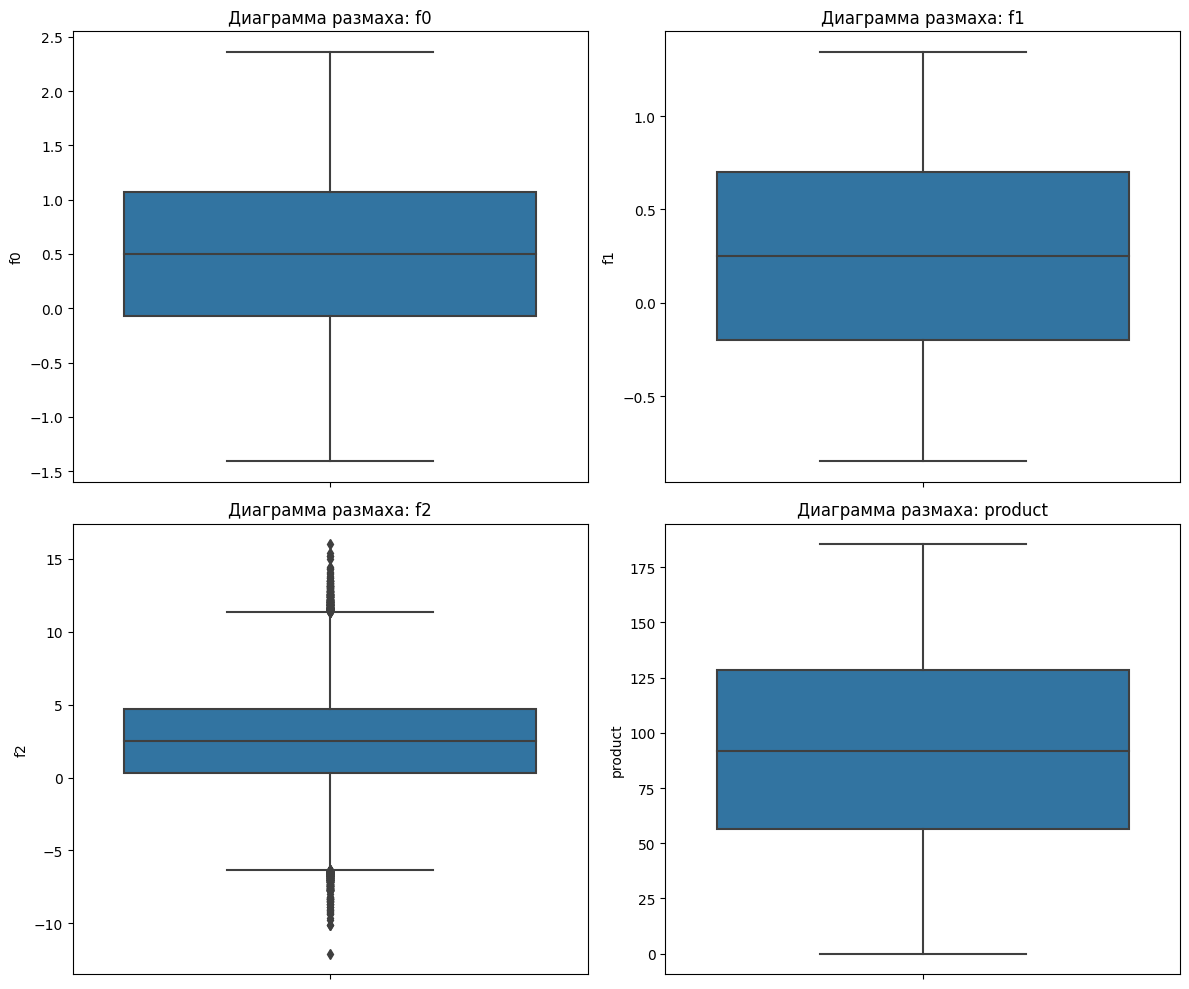

In [304]:
# Создаем визуализатор
viz_reg_00 = Visualizer(df_region_first.data)

# Строим ящик с усами по признакам с непрерывным характером значений
viz_reg_00.boxplot(y=['f0', 'f1', 'f2', 'product'])

* На графике по признаку `f2` обнаружены выбросы в диапазоне значений:
    * менее -5
    * более 10

#### Второй регион

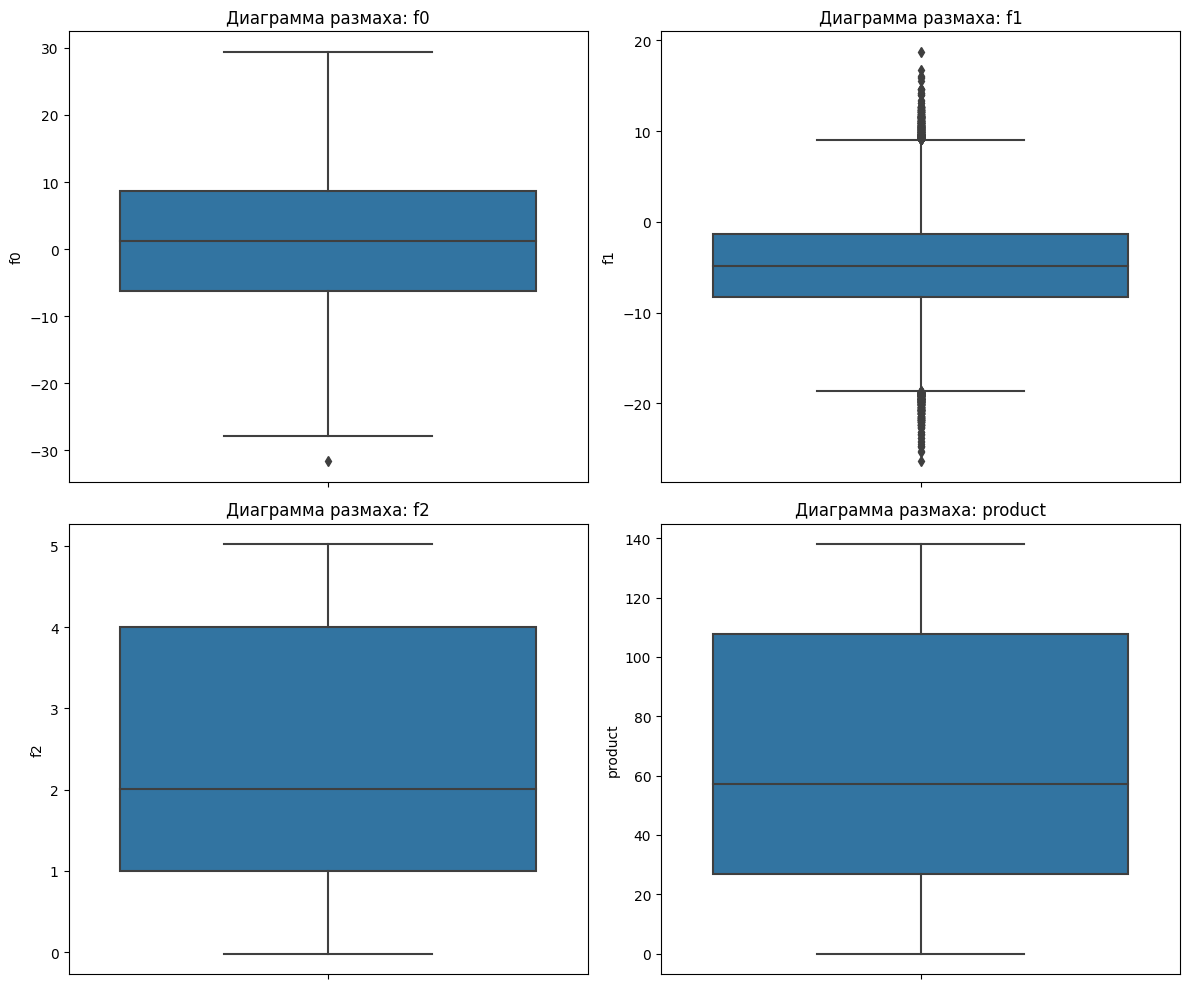

In [305]:
# Создаем визуализатор
viz_reg_01 = Visualizer(df_region_second.data)

# Строим ящик с усами по признакам с непрерывным характером значений
viz_reg_01.boxplot(y=['f0', 'f1', 'f2', 'product'])

* На графике по признаку `f1` обнаружены выбросы в диапазоне значений:
    * менее -20
    * более 10

#### Третий регион

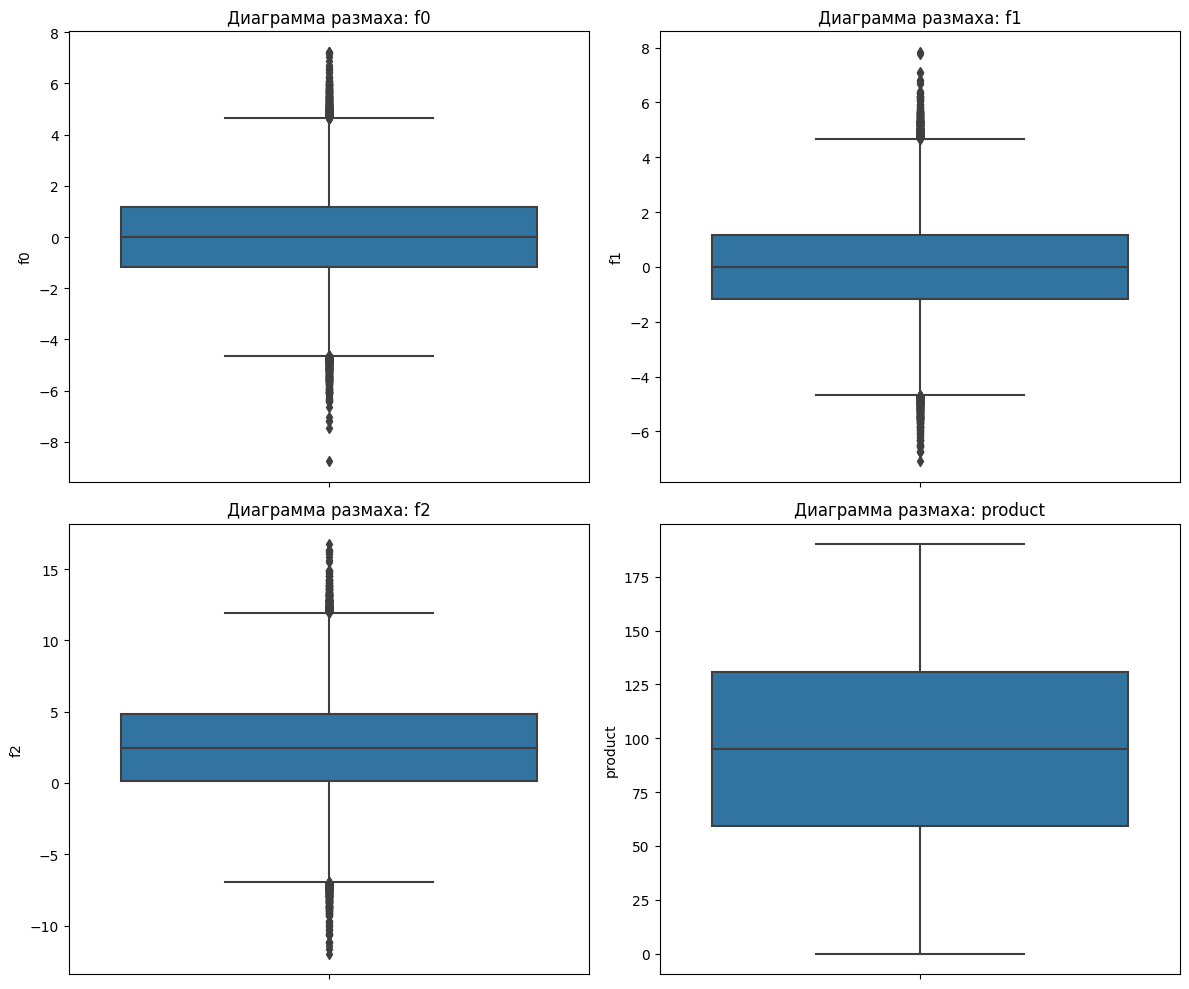

In [306]:
# Создаем визуализатор
viz_reg_02 = Visualizer(df_region_third.data)

# Строим ящик с усами по признакам с непрерывным характером значений
viz_reg_02.boxplot(y=['f0', 'f1', 'f2', 'product'])

* На графике обнаружены выбросы по всем признакам в диапазоне значений:
    * `f0`:
        * менее -5
        * более 5
    * `f1`:
        * менее -5
        * более 5
    * `f2`:
        * менее -6
        * более 12

#### Комментарии к диаграммам размаха

* На графике **признаков первого региона** по признаку `f2` обнаружены выбросы в диапазоне значений:
    * менее -5
    * более 10
    
* На графике **признаков второго региона** по признаку `f1` обнаружены выбросы в диапазоне значений:
    * менее -20
    * более 10
    
* На графике **признаков третьего региона** обнаружены выбросы по всем признакам в диапазоне значений:
    * `f0`:
        * менее -5
        * более 5
    * `f1`:
        * менее -5
        * более 5
    * `f2`:
        * менее -6
        * более 12
        
* Дополнительно отметим, что по второму региону наблюдается более широкий межквартильный размах по объёму запасов в скважине - от 30 до 110 тыс. баррелей, тогда как по первому и третьему регионам он составил от 60 до 125 тыс. баррелей.

### Диаграммы распределения

#### Первый регион

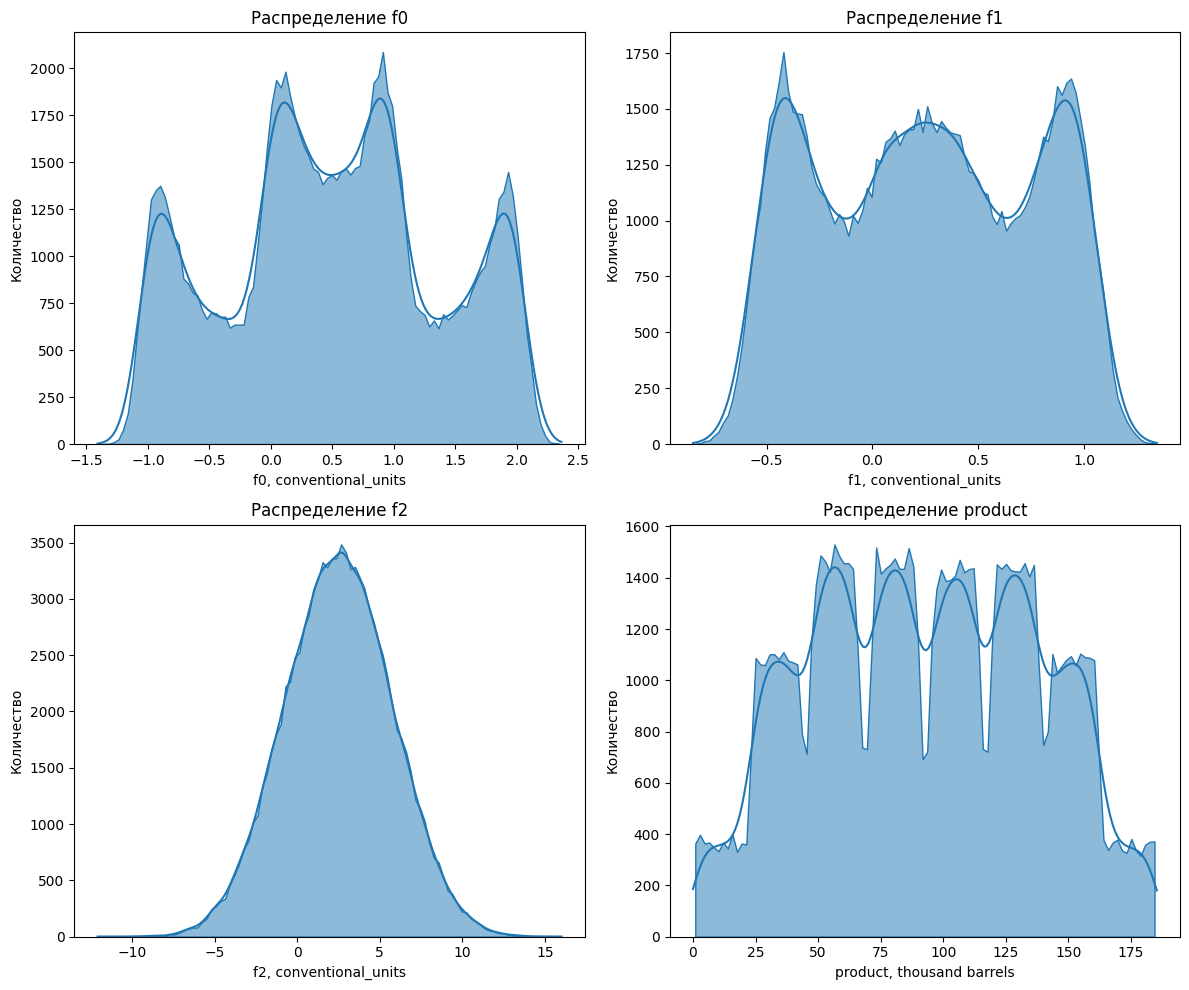

In [307]:
# Строим график
viz_reg_00.histplot(x=['f0', 'f1', 'f2', 'product'], \
                    measurement=['conventional_units', 'conventional_units', 'conventional_units', 'thousand barrels'])

Проверка на нормальность распределения

In [308]:
# Создаем список столбцов для проведения теста
df_reg_01_columns = ['f0', 'f1', 'f2', 'product']

# Проверим распределение на нормальность с помощью теста
for column in df_reg_01_columns:
    stat, p = normaltest(df_region_first.data[column])
    if p < 0.05:
        print(f"Распределение признака {column} НЕ распределено нормально")
    else:
        print(f"Распределение признака {column} распределено нормально")
    print('*' * 5)

Распределение признака f0 НЕ распределено нормально
*****
Распределение признака f1 НЕ распределено нормально
*****
Распределение признака f2 НЕ распределено нормально
*****
Распределение признака product НЕ распределено нормально
*****


#### Второй регион

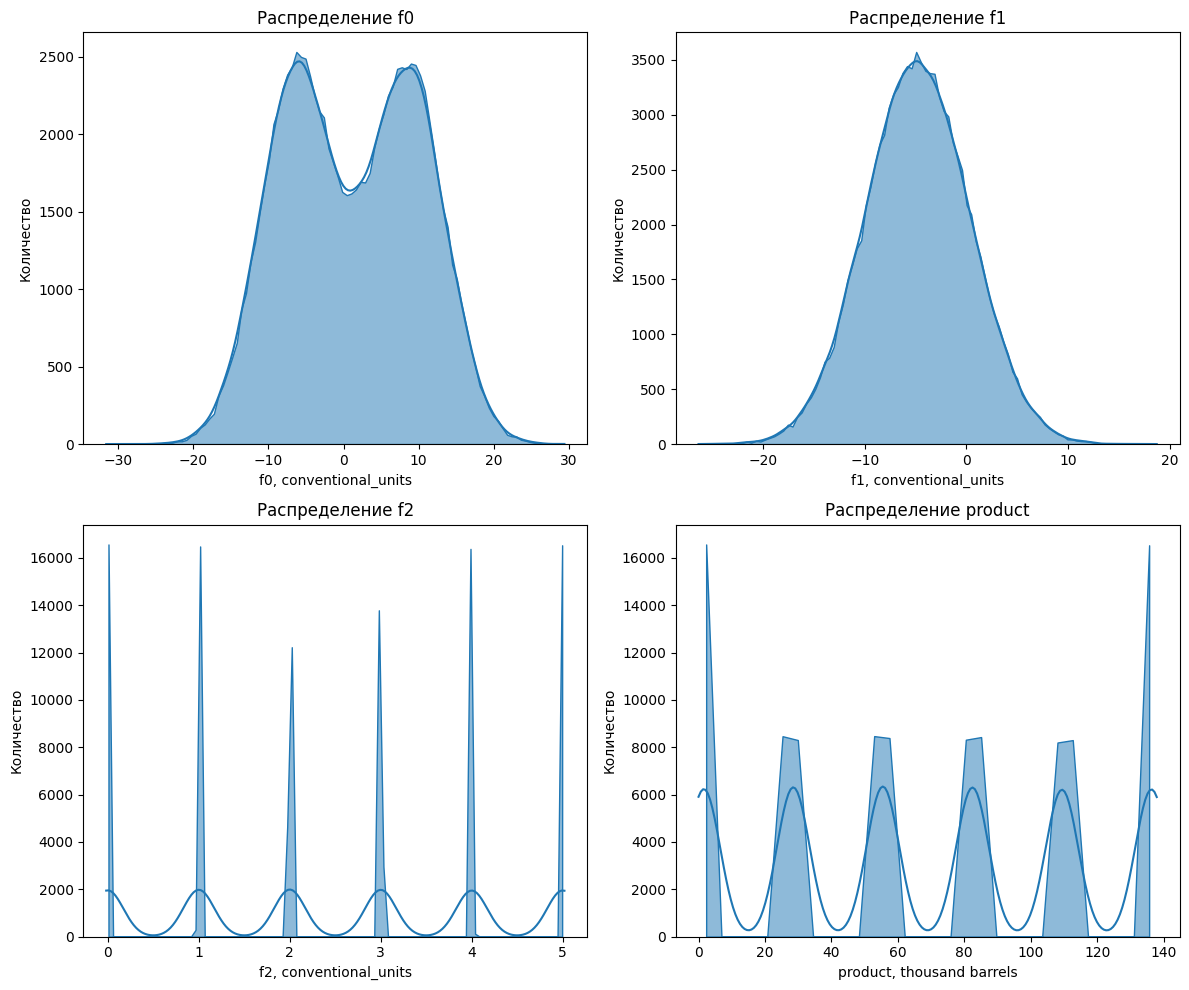

In [309]:
# Строим график
viz_reg_01.histplot(x=['f0', 'f1', 'f2', 'product'], \
                    measurement=['conventional_units', 'conventional_units', 'conventional_units', 'thousand barrels'])

Проверка на нормальность распределения

In [310]:
# Создаем список столбцов для проведения теста
df_reg_02_columns = ['f0', 'f1', 'f2', 'product']

# Проверим распределение на нормальность с помощью теста
for column in df_reg_02_columns:
    stat, p = normaltest(df_region_second.data[column])
    if p < 0.05:
        print(f"Распределение признака {column} НЕ распределено нормально")
    else:
        print(f"Распределение признака {column} распределено нормально")
    print('*' * 5)

Распределение признака f0 НЕ распределено нормально
*****
Распределение признака f1 НЕ распределено нормально
*****
Распределение признака f2 НЕ распределено нормально
*****
Распределение признака product НЕ распределено нормально
*****


#### Третий регион

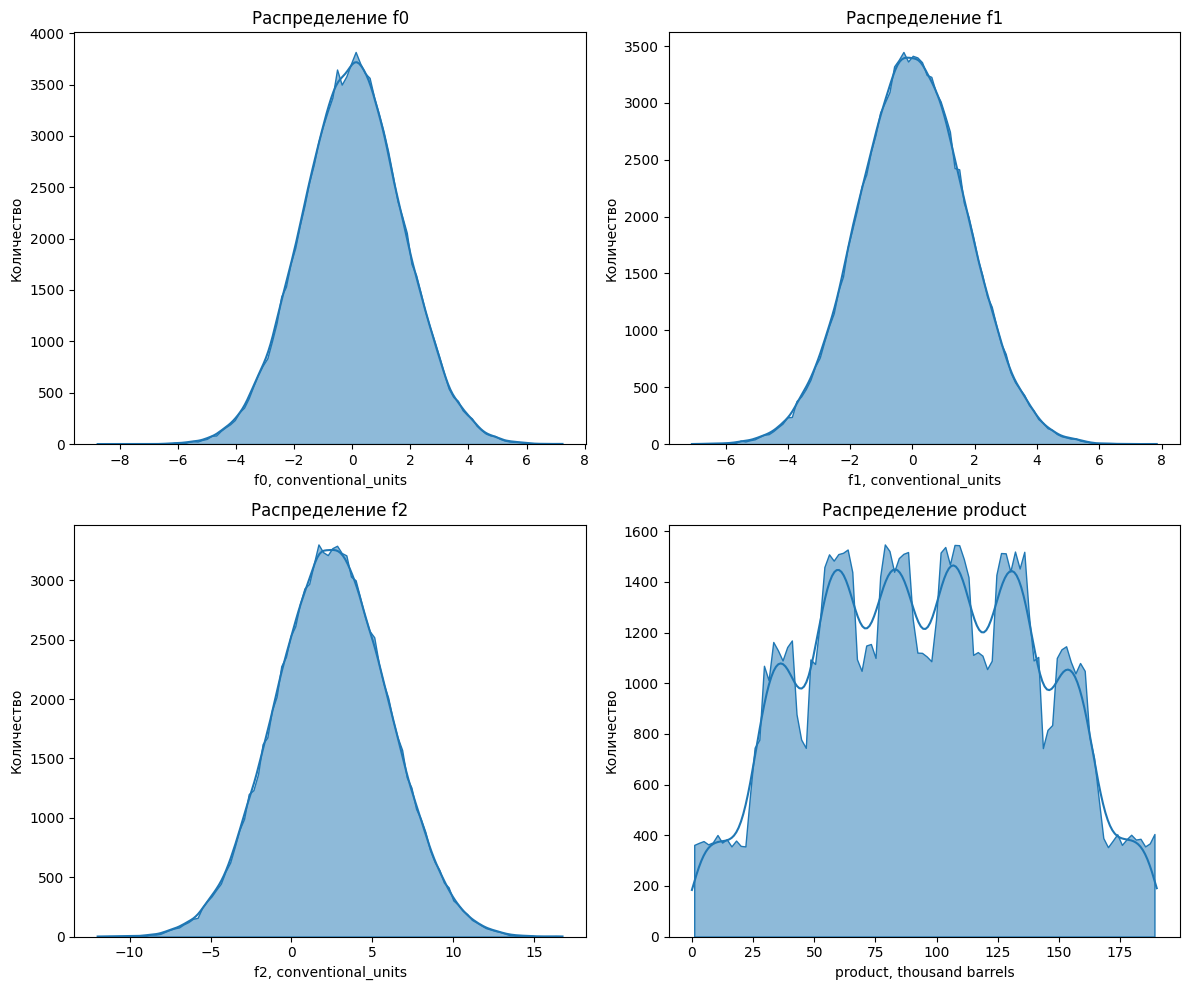

In [311]:
# Строим график
viz_reg_02.histplot(x=['f0', 'f1', 'f2', 'product'], \
                    measurement=['conventional_units', 'conventional_units', 'conventional_units', 'thousand barrels'])

Проверка на нормальность распределения

In [312]:
# Создаем список столбцов для проведения теста
df_reg_03_columns = ['f0', 'f1', 'f2', 'product']

# Проверим распределение на нормальность с помощью теста
for column in df_reg_03_columns:
    stat, p = normaltest(df_region_third.data[column])
    if p < 0.05:
        print(f"Распределение признака {column} НЕ распределено нормально")
    else:
        print(f"Распределение признака {column} распределено нормально")
    print('*' * 5)

Распределение признака f0 распределено нормально
*****
Распределение признака f1 распределено нормально
*****
Распределение признака f2 НЕ распределено нормально
*****
Распределение признака product НЕ распределено нормально
*****


#### Комментарии к диаграммам распределения

**Первый регион**
* Распределение признаков `f0`, `f1`, `product` мультимодальные, `f2` - унимодальное
* Признаки НЕ распределены нормально

**Второй регион**
* Признаки `f2` и `product` имеют дискретный характер распределения
* Распределение признака `f1` - унимодальное, остальные признаки - мультимодальные
* Признаки НЕ распределены нормально

**Третий регион**
* Распределение признаков `f0`, `f1`, `f2`, - унимодальное, `product` - мультимодальное
* Признаки `f0`, `f1` распределены нормально
* Признаки `f2`, `product` распределены нормально

### Альтернативные диаграммы для второго региона

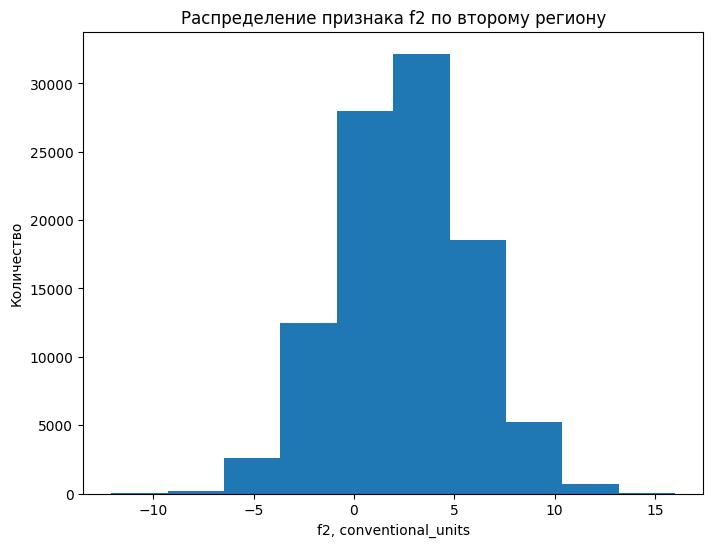

In [313]:
# Указываем размер графика
plt.figure(figsize=(8,6))

# Строим график для признака f2
plt.hist(df_region_first.data['f2'])

# Указываем подписи к графику
plt.title('Распределение признака f2 по второму региону')
plt.xlabel('f2, conventional_units')
plt.ylabel('Количество')

# Выводи на экран
plt.show()

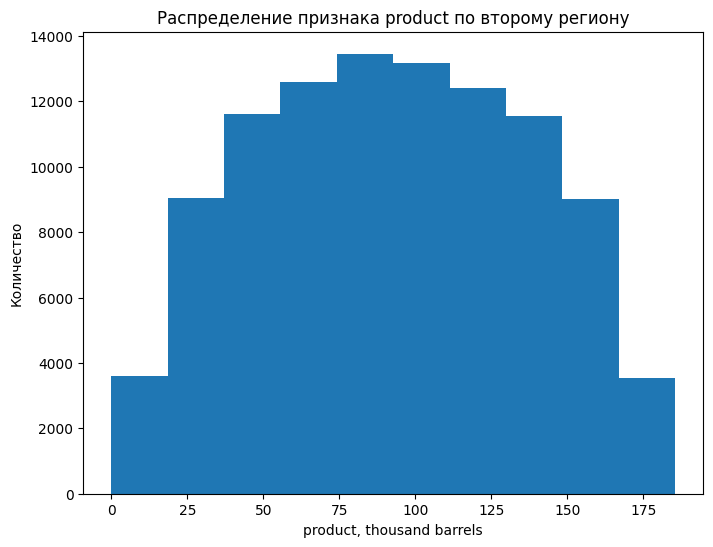

In [314]:
# Указываем размер графика
plt.figure(figsize=(8,6))

# Строим график для признака f2
plt.hist(df_region_first.data['product'])

# Указываем подписи к графику
plt.title('Распределение признака product по второму региону')
plt.xlabel('product, thousand barrels')
plt.ylabel('Количество')

# Выводи на экран
plt.show()

### Диаграмма рассения

#### Первый регион

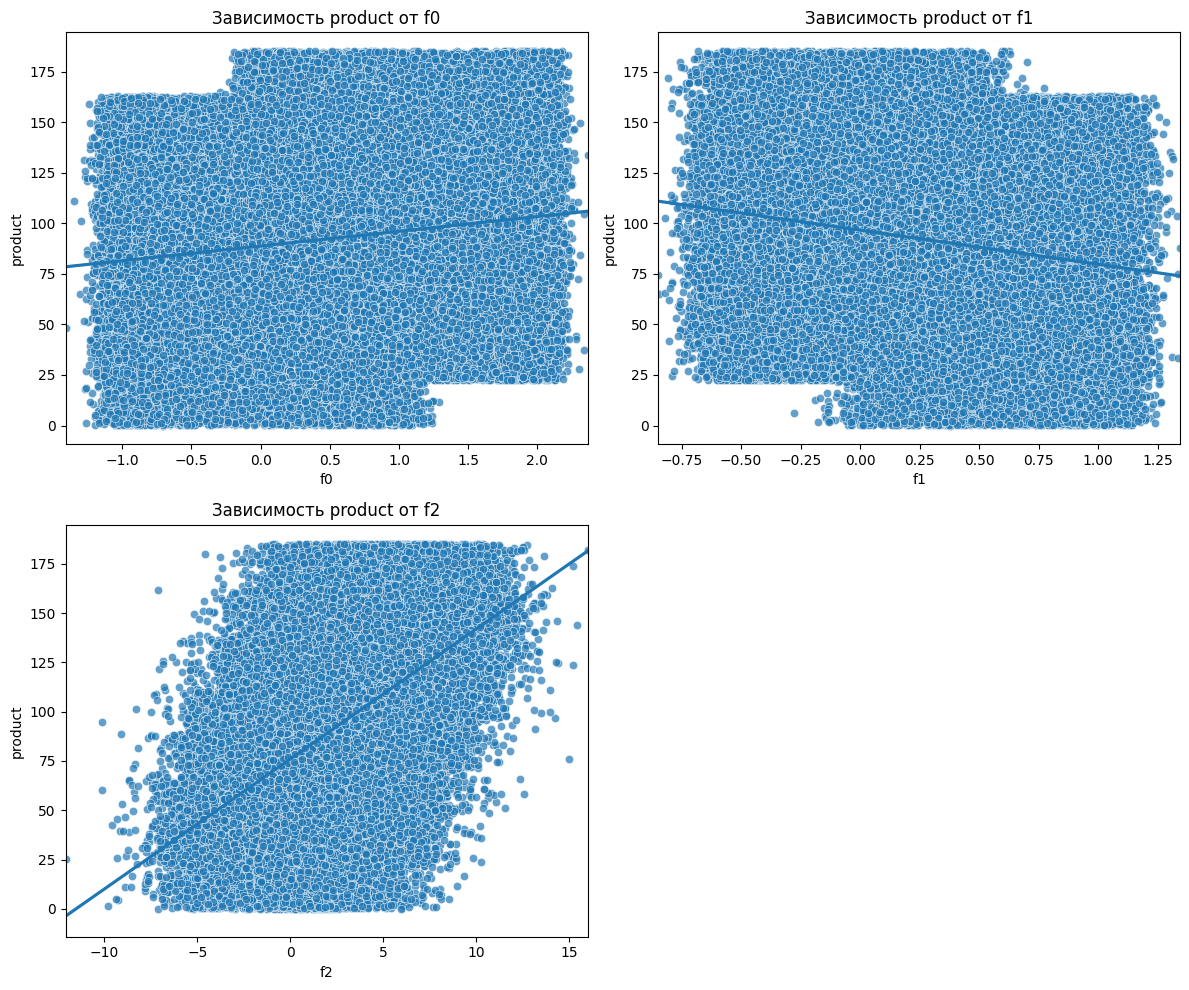

In [315]:
# Строим диаграмму рассеяния
viz_reg_00.scatterplot(x=['f0', 'f1', 'f2'], y='product')

#### Второй регион

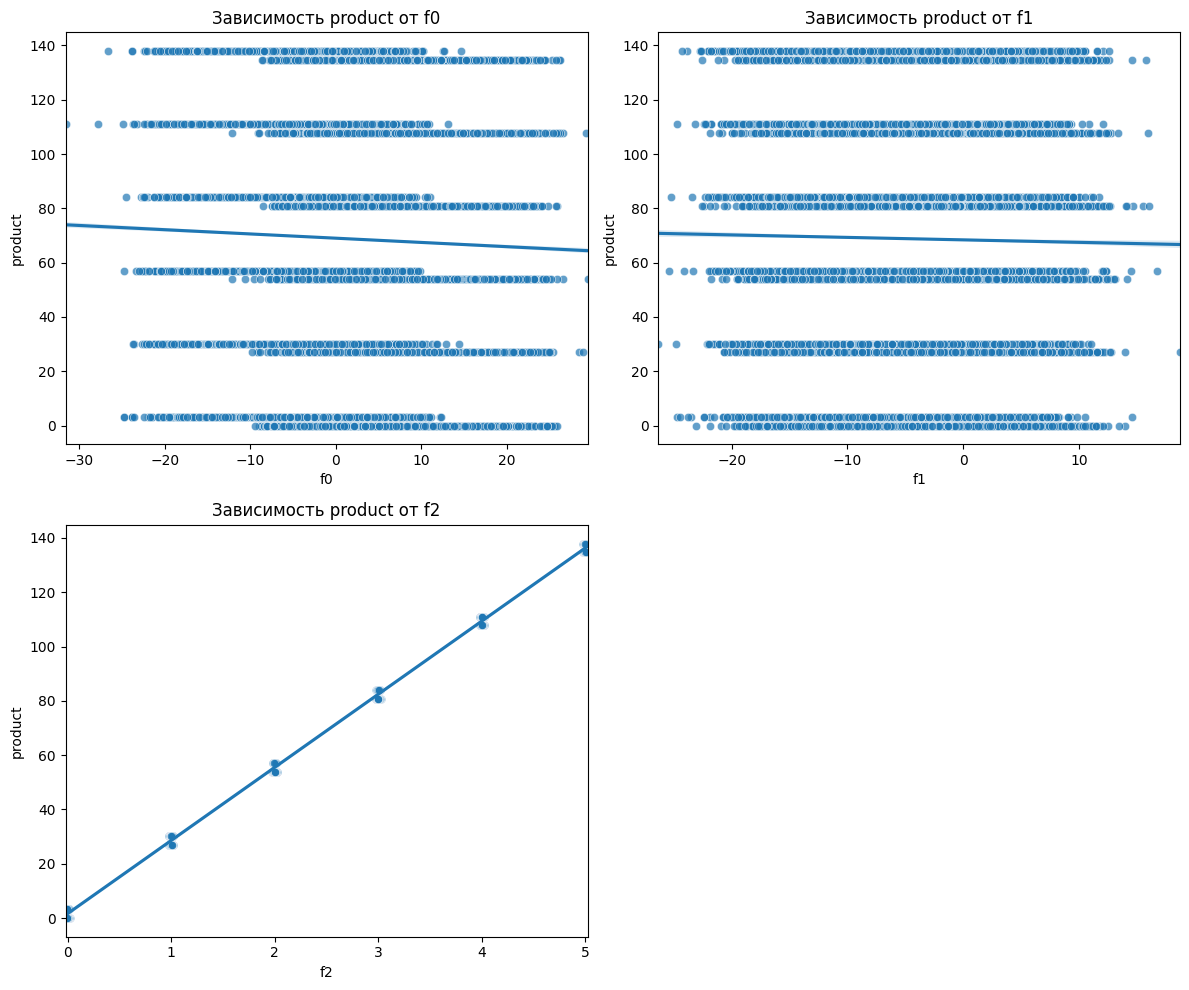

In [316]:
# Строим диаграмму рассеяния
viz_reg_01.scatterplot(x=['f0', 'f1', 'f2'], y='product')

#### Третий регион

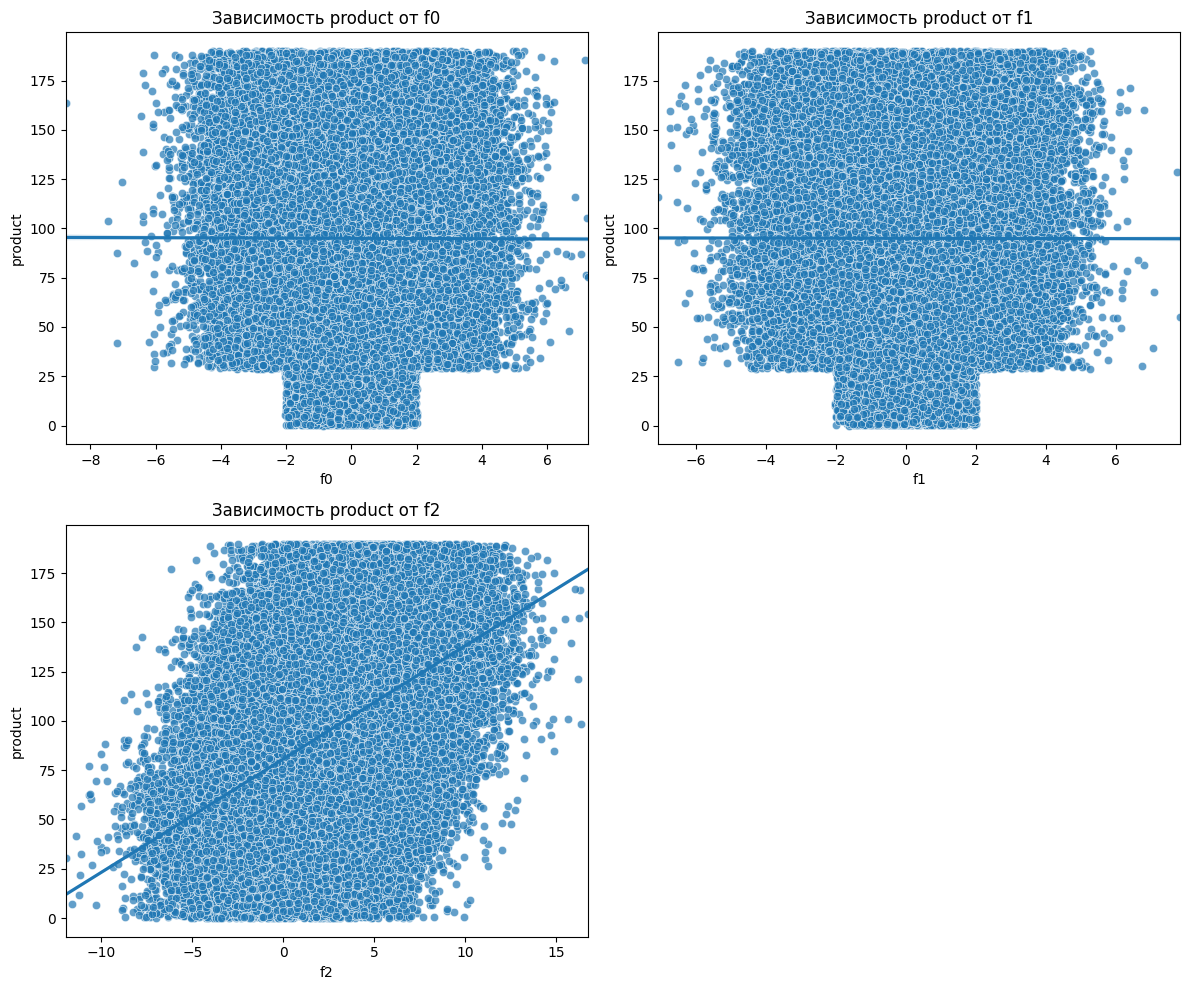

In [317]:
# Строим диаграмму рассеяния
viz_reg_02.scatterplot(x=['f0', 'f1', 'f2'], y='product')

#### Комментарии к диаграммам рассения

**Первый регион**
* корреляция объема запасов и признаков `f0` и `f2` имеет положительный характер (с `f2` корреляция сильнее)
* корреляция объема запасов и признака `f1` имеет отрицательный характер

**Второй регион**
* корреляция объема запасов и признаков `f0` и `f1` имеет слабо выраженный отрицательный характер
* корреляция объема запасов и признака `f2` имеет положительный характер

**Третий регион**
* корреляция объема запасов и признаков `f0` и `f1` имеет слабо выраженный отрицательный характер
* корреляция объема запасов и признака `f2` имеет положительный характер

### Корреляционный анализ

#### Первый регион

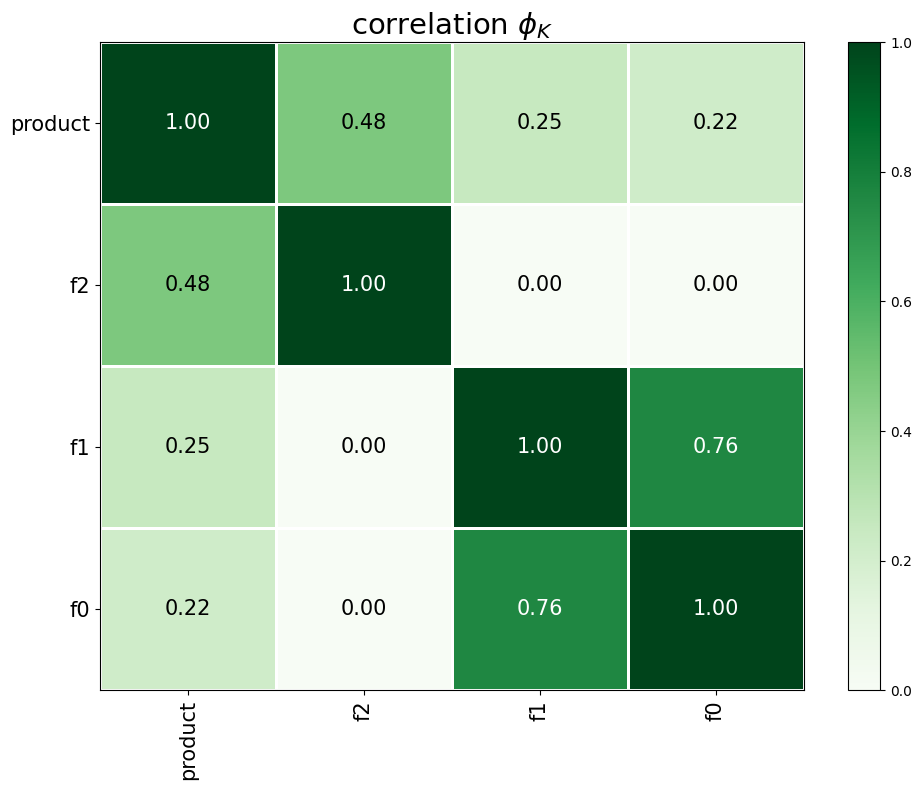

In [318]:
# Создаём список с наименованиями непрерывных признаков
interval_cols_region_first = ['product', 'f0', 'f1', 'f2']

# Считаем корреляции на тренировочной выборке
phik_overview_region_first = phik_matrix(df_region_first.data.drop(['id'], axis=1), interval_cols=interval_cols_region_first)

# Визуализируем матрицу корреляции
plot_correlation_matrix(
    phik_overview_region_first.values,
    x_labels=phik_overview_region_first.columns,
    y_labels=phik_overview_region_first.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 8)
)

#### Второй регион

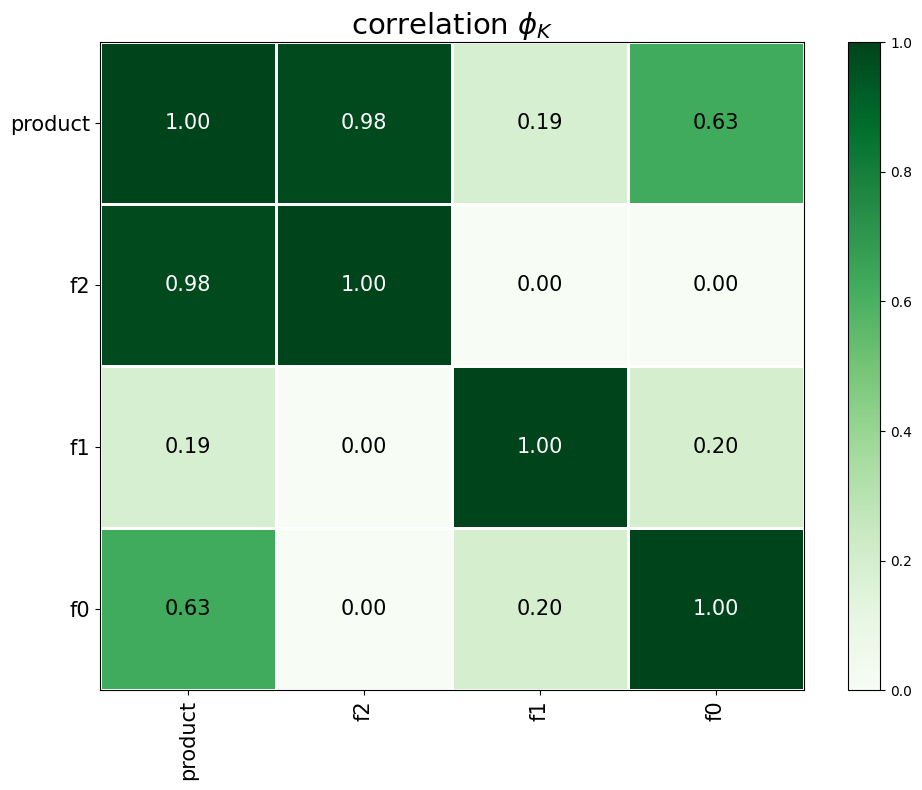

In [319]:
# Создаём список с наименованиями непрерывных признаков
interval_cols_region_second = ['product', 'f0', 'f1', 'f2']

# Считаем корреляции на тренировочной выборке
phik_overview_region_second = phik_matrix(df_region_second.data.drop(['id'], axis=1), interval_cols=interval_cols_region_second)

# Визуализируем матрицу корреляции
plot_correlation_matrix(
    phik_overview_region_second.values,
    x_labels=phik_overview_region_second.columns,
    y_labels=phik_overview_region_second.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 8)
)

#### Третий регион

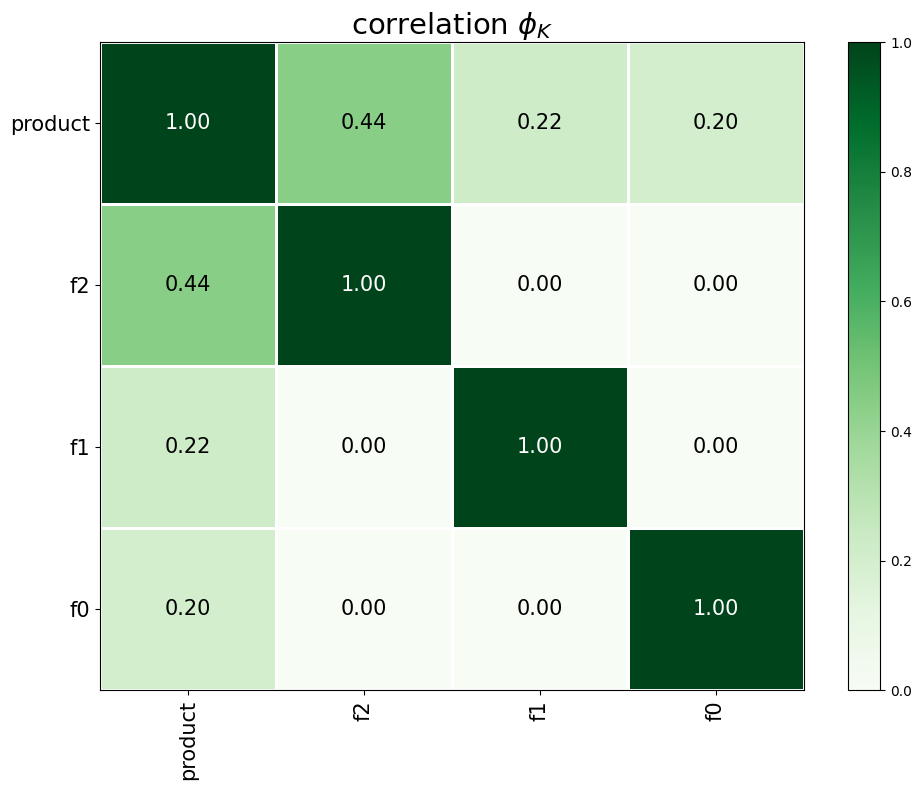

In [320]:
# Создаём список с наименованиями непрерывных признаков
interval_cols_region_third = ['product', 'f0', 'f1', 'f2']

# Считаем корреляции на тренировочной выборке
phik_overview_region_third = phik_matrix(df_region_third.data.drop(['id'], axis=1), interval_cols=interval_cols_region_third)

# Визуализируем матрицу корреляции
plot_correlation_matrix(
    phik_overview_region_third.values,
    x_labels=phik_overview_region_third.columns,
    y_labels=phik_overview_region_third.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 8)
)

#### Комментарии к корреляционному анализу

* Мультиколлениарность признаков не обнаружена

**Первый регион**
* Самый важный признак для объема запасов `f2` (0.48)

**Второй регион**
* Самые важные признаки для объема запасов `f2` (0.98) и `f0` (0.63)

**Третий регион**
* Самый важный признак для объема запасов `f2` (0.44)

## Обучение и проверка модели

### Особенности данных

* Все признаки количественные, поэтому их потребуется масштабировать

### Выбор метрики

* В качестве метрики качества модели выберем показатель RMSE (корень из среднеквадратичной ошибки)
* RMSE - это метрика, которая измеряется в единицах целевого признака, поэтому её легче интерпретировать, чем, например, MSE
* Лучшее значение RMSE стремится к нулю
* Порог успешного значения метрики RMSE бизнесом не задан

### Первый регион

#### Пайплайн модели по первому региону

In [321]:
# ================== 0. Предварительно отсортируем данные по id ==================
df_region_first.data = (
    df_region_first.data
        .sort_values(by='id')
        .set_index('id')
)

# ================== 1. Разделяем выборку ==================

# Разделяем выборку на тестовую и тренировочную
X_train_reg_01, X_test_reg_01, y_train_reg_01, y_test_reg_01 = train_test_split(
    df_region_first.data.drop(['product'], axis=1),
    df_region_first.data['product'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

# ================== 2. Определяем признаки ==================

# Создаем списки с названиями признаков
num_columns = ['f0', 'f1', 'f2']

# ================== 3. Пайплайн обработки ==================

# Создаём общий пайплан для подготовки данных
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

# ================== 4. Финальный пайплайн ==================

# Создаём итоговый пайплан: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

# ================== 5. Кросс-валидация на всём тренировочном датасете ==================

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = cross_val_score(
    pipe_final,
    X_train_reg_01,
    y_train_reg_01,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

print('RMSE по фолдам тренировочного датасета:', [f'{abs(score):.0f}' for score in cv_scores])
print(f'Средний RMSE: {abs(cv_scores.mean()):.0f}')
print(f'Стандартное отклонение: {cv_scores.std():.1f}')

# ================== 6. Оценка на валидационной выборке ==================

pipe_final.fit(X_train_reg_01, y_train_reg_01)
y_pred_reg_01 = pipe_final.predict(X_test_reg_01)

rmse_test_reg_01 = mean_squared_error(y_test_reg_01, y_pred_reg_01, squared=False)
print(f'Метрика RMSE на тестовой выборке: {rmse_test_reg_01:.0f}')
print(f'Средний запас предсказанного сырья: {y_pred_reg_01.mean():.0f} тыс. баррелей')

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is sla

RMSE по фолдам тренировочного датасета: ['37', '38', '38', '38', '38']
Средний RMSE: 38
Стандартное отклонение: 0.2
Метрика RMSE на тестовой выборке: 38
Средний запас предсказанного сырья: 92 тыс. баррелей


#### Объединение предсказаний и целевого признака

In [322]:
# Объединяем правильные ответы и предсказания в один датасет
df_result_reg_01 = pd.DataFrame({
    'y_true': y_test_reg_01,
    'y_pred': y_pred_reg_01
}, index=X_test_reg_01.index).reset_index()

# Смотрим на результат
df_result_reg_01.head()

id  y_true  y_pred
0  kz06D   70.79   89.91
1  nmARb   78.12   78.87
2  CFf4y   91.91   79.37
3  lbPfa   50.87   90.24
4  viqqq   29.27   58.32

#### Анализ остатков

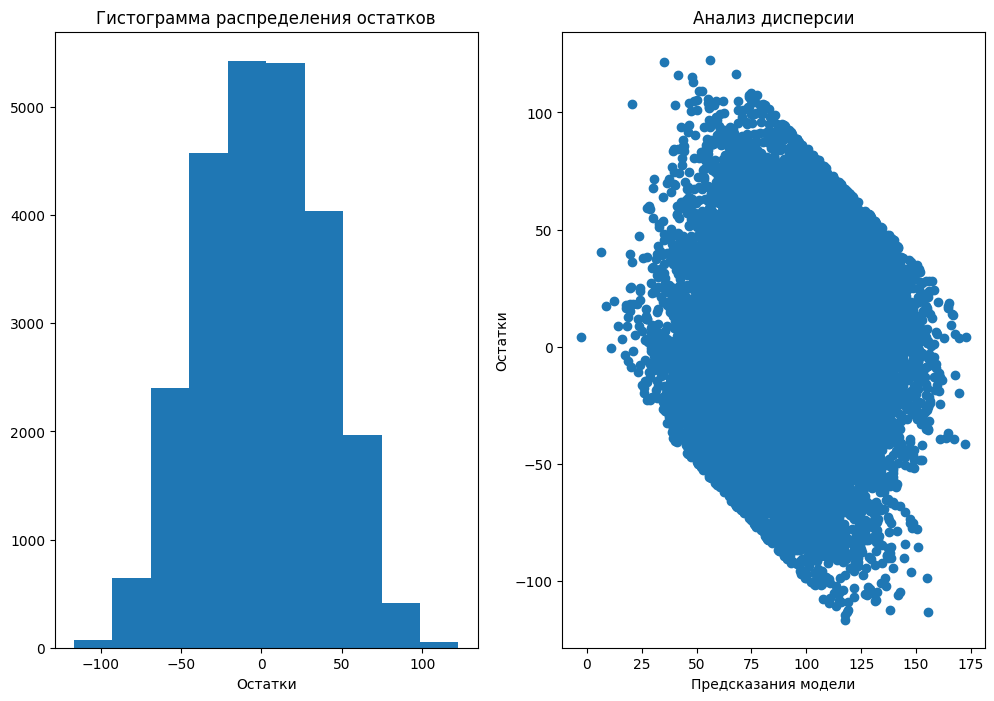

In [323]:
# Проведем анализ остатков, предварительно рассчитаем остатки
residuals_reg_01 = y_test_reg_01.values - y_pred_reg_01

# Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axes[0].hist(residuals_reg_01)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred_reg_01, y=residuals_reg_01)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

# Вывод на экран
plt.show()

#### Промежуточные выводы

Результаты модели по **первому** региону:
* Метрика RMSE на тестовой выборке: 38
* Средний запас предсказанного сырья: 92 тыс. баррелей
* Распределение остатков близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков НЕравномерная, значения распределены по характерному паттерну, что может свидительствовать о нестабильности модели

### Второй регион

#### Пайплайн модели по второму региону

In [324]:
# ================== 0. Предварительно отсортируем данные по id ==================
df_region_second.data = (
    df_region_second.data
        .sort_values(by='id')
        .set_index('id')
)

# ================== 1. Разделяем выборку ==================

# Разделяем выборку на тестовую и тренировочную
X_train_reg_02, X_test_reg_02, y_train_reg_02, y_test_reg_02 = train_test_split(
    df_region_second.data.drop(['product'], axis=1),
    df_region_second.data['product'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

# ================== 2. Определяем признаки ==================

# Создаем списки с названиями признаков
num_columns = ['f0', 'f1', 'f2']

# ================== 3. Пайплайн обработки ==================

# Создаём общий пайплан для подготовки данных
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

# ================== 4. Финальный пайплайн ==================

# Создаём итоговый пайплан: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

# ================== 5. Кросс-валидация на всём тренировочном датасете ==================

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = cross_val_score(
    pipe_final,
    X_train_reg_02,
    y_train_reg_02,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

print('RMSE по фолдам тренировочного датасета:', [f'{abs(score):.0f}' for score in cv_scores])
print(f'Средний RMSE: {abs(cv_scores.mean()):.0f}')
print(f'Стандартное отклонение: {cv_scores.std():.1f}')

# ================== 6. Оценка на валидационной выборке ==================

pipe_final.fit(X_train_reg_02, y_train_reg_02)
y_pred_reg_02 = pipe_final.predict(X_test_reg_02)

rmse_test_reg_02 = mean_squared_error(y_test_reg_02, y_pred_reg_02, squared=False)
print(f'Метрика RMSE на тестовой выборке: {rmse_test_reg_02:.0f}')
print(f'Средний запас предсказанного сырья: {y_pred_reg_02.mean():.0f} тыс. баррелей')

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is sla

RMSE по фолдам тренировочного датасета: ['1', '1', '1', '1', '1']
Средний RMSE: 1
Стандартное отклонение: 0.0
Метрика RMSE на тестовой выборке: 1
Средний запас предсказанного сырья: 69 тыс. баррелей


#### Объединение предсказаний и целевого признака

In [325]:
# Объединяем правильные ответы и предсказания в один датасет
df_result_reg_02 = pd.DataFrame({
    'y_true': y_test_reg_02,
    'y_pred': y_pred_reg_02
}, index=X_test_reg_02.index).reset_index()

# Смотрим на результат
df_result_reg_02.head()

id  y_true  y_pred
0  ksHYQ    3.18    4.10
1  ngLE2  134.77  136.00
2  CIj94   53.91   53.53
3  lVc5R   57.09   56.21
4  vfVtG    3.18    2.50

#### Анализ остатков

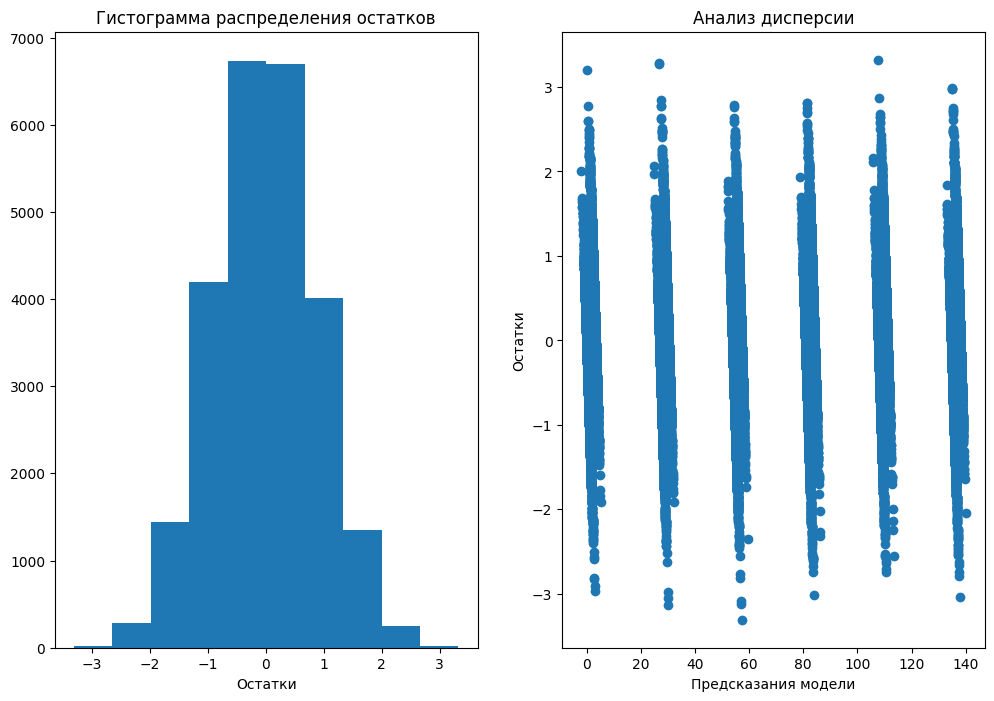

In [326]:
# Проведем анализ остатков, предварительно рассчитаем остатки
residuals_reg_02 = y_test_reg_02.values - y_pred_reg_02

# Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axes[0].hist(residuals_reg_02)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred_reg_02, y=residuals_reg_02)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

# Вывод на экран
plt.show()

#### Промежуточные выводы

Результаты модели по **второму** региону:
* Метрика RMSE на тестовой выборке: 1
* Средний запас предсказанного сырья: 69 тыс. баррелей
* Распределение остатков близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков НЕравномерная, значения распределены по характерному паттерну, что может свидительствовать о нестабильности модели

### Третий регион

#### Пайплайн модели по третьему региону

In [327]:
# ================== 0. Предварительно отсортируем данные по id ==================
df_region_third.data = (
    df_region_third.data
        .sort_values(by='id')
        .set_index('id')
)

# ================== 1. Разделяем выборку ==================

# Разделяем выборку на тестовую и тренировочную
X_train_reg_03, X_test_reg_03, y_train_reg_03, y_test_reg_03 = train_test_split(
    df_region_third.data.drop(['product'], axis=1),
    df_region_third.data['product'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

# ================== 2. Определяем признаки ==================

# Создаем списки с названиями признаков
num_columns = ['f0', 'f1', 'f2']

# ================== 3. Пайплайн обработки ==================

# Создаём общий пайплан для подготовки данных
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

# ================== 4. Финальный пайплайн ==================

# Создаём итоговый пайплан: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

# ================== 5. Кросс-валидация на всём тренировочном датасете ==================

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = cross_val_score(
    pipe_final,
    X_train_reg_03,
    y_train_reg_03,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

print('RMSE по фолдам тренировочного датасета:', [f'{abs(score):.0f}' for score in cv_scores])
print(f'Средний RMSE: {abs(cv_scores.mean()):.0f}')
print(f'Стандартное отклонение: {cv_scores.std():.1f}')

# ================== 6. Оценка на валидационной выборке ==================

pipe_final.fit(X_train_reg_03, y_train_reg_03)
y_pred_reg_03 = pipe_final.predict(X_test_reg_03)

rmse_test_reg_03 = mean_squared_error(y_test_reg_03, y_pred_reg_03, squared=False)
print(f'Метрика RMSE на тестовой выборке: {rmse_test_reg_03:.0f}')
print(f'Средний запас предсказанного сырья: {y_pred_reg_03.mean():.0f} тыс. баррелей')

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


RMSE по фолдам тренировочного датасета: ['40', '40', '40', '40', '40']
Средний RMSE: 40
Стандартное отклонение: 0.1
Метрика RMSE на тестовой выборке: 40
Средний запас предсказанного сырья: 95 тыс. баррелей


#### Объединение предсказаний и целевого признака

In [328]:
# Объединяем правильные ответы и предсказания в один датасет
df_result_reg_03 = pd.DataFrame({
    'y_true': y_test_reg_03,
    'y_pred': y_pred_reg_03
}, index=X_test_reg_03.index).reset_index()

# Смотрим на результат
df_result_reg_03.head()

id  y_true  y_pred
0  kvoJ2  185.36   83.55
1  nh6w7   49.43   91.40
2  CDLub   61.53   92.78
3  lWDr6   86.66   97.22
4  veJ3P   89.68   99.01

#### Анализ остатков

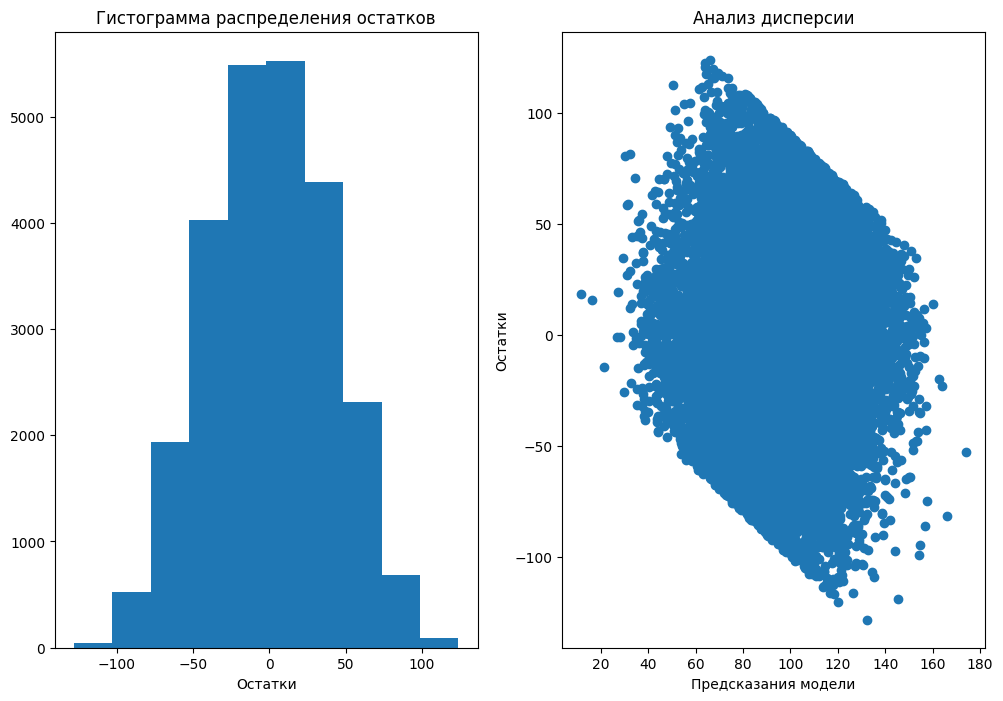

In [329]:
# Проведем анализ остатков, предварительно рассчитаем остатки
residuals_reg_03 = y_test_reg_03.values - y_pred_reg_03

# Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axes[0].hist(residuals_reg_03)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred_reg_03, y=residuals_reg_03)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

# Вывод на экран
plt.show()

#### Промежуточные выводы

Результаты модели по **третьему** региону:
* Метрика RMSE на тестовой выборке: 40
* Средний запас предсказанного сырья: 95 тыс. баррелей
* Распределение остатков близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков НЕравномерная, значения распределены по характерному паттерну, что может свидительствовать о нестабильности модели

## Подготовка к расчёту прибыли

### Расчет объема добываемого сырья для безубыточности

In [330]:
# Фиксируем бюджет на разработку скважин в регионе в тыс. руб.
budget = 10_000_000

# Количество скважин для разработки
wells_for_development = 200

# Средний бюджет на разработку одной скважины в регионе в тыс. руб.
budget_per_well = budget / wells_for_development
print(f'Средний бюджет на разработку одной скважины в регионе {budget_per_well:.0f} тыс. руб.')

# Фиксируем доход с единицы продукции в тыс. руб.
revenue_per_thousand_barrels = 450

# Расчитаем объем добычи для безубыточности
min_extraction_volume = budget_per_well / revenue_per_thousand_barrels
print(f'Средний объем добычи с одной скважины для достижения безубыточности должен составлять \
{min_extraction_volume:.0f} тыс. баррелей')

# Фиксируем заданный порог вероятности убытка
probability_of_loss = 0.025

Средний бюджет на разработку одной скважины в регионе 50000 тыс. руб.
Средний объем добычи с одной скважины для достижения безубыточности должен составлять 111 тыс. баррелей


### Сравнение с запасами в регионах

In [331]:
# Список регионов
region_list = ['region_first', 'region_second', 'region_third']

# Считаем средний запас сырья в каждом регионе
mean_product_reg_01 = df_region_first.data['product'].mean()
mean_product_reg_02 = df_region_second.data['product'].mean()
mean_product_reg_03 = df_region_third.data['product'].mean()

# Считаем абсолютные отклонения
abs_diff_reg_01 = min_extraction_volume - mean_product_reg_01
abs_diff_reg_02 = min_extraction_volume - mean_product_reg_02
abs_diff_reg_03 = min_extraction_volume - mean_product_reg_03
abs_diff_list = [abs_diff_reg_01, abs_diff_reg_02, abs_diff_reg_03]

# Считаем относительные отклонения
relative_diff_reg_01 = (min_extraction_volume / mean_product_reg_01 - 1) * 100
relative_diff_reg_02 = (min_extraction_volume / mean_product_reg_02 - 1) * 100
relative_diff_reg_03 = (min_extraction_volume / mean_product_reg_03 - 1) * 100
relative_diff_list = [relative_diff_reg_01, relative_diff_reg_02, relative_diff_reg_03]

# Считаем отклонения относительно расчитанного объема безубыточности
for region, abs_diff, relative_diff in zip(region_list, abs_diff_list, relative_diff_list):
    print(f'Отклонения среднего объема добычи для безубыточности от запасов в {region} составили:')
    print(f'{abs_diff:.1f} тыс. баррелей')
    print(f'{relative_diff:.1f}%')

Отклонения среднего объема добычи для безубыточности от запасов в region_first составили:
18.6 тыс. баррелей
20.1%
Отклонения среднего объема добычи для безубыточности от запасов в region_second составили:
42.3 тыс. баррелей
61.4%
Отклонения среднего объема добычи для безубыточности от запасов в region_third составили:
16.1 тыс. баррелей
17.0%


### Промежуточные выводы

* Средний бюджет на разработку одной скважины в регионе 50000 тыс. руб.
* Средний объем добычи с одной скважины для достижения безубыточности должен составлять 111 тыс. баррелей

Отклонения среднего объема добычи для безубыточности от запасов в первом регионе составили:
* 18.6 тыс. баррелей
* 20.1%

Отклонения среднего объема добычи для безубыточности от запасов во втором регионе составили:
* 42.3 тыс. баррелей
* 61.4%

Отклонения среднего объема добычи для безубыточности от запасов в третьем регионе составили:
* 16.1 тыс. баррелей
* 17.0%

## Расчёт прибыли и рисков 

### Условия эксперимента

* Использовать технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
* Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков (убыток - отрицательная прибыль)
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью

### Проведение эксперимента

In [332]:
# Отбор 500 самых продуктивных скважин
def profit_count(df: pd.DataFrame, product_predicted: str, product_true: str, wells_amount: int, revenue_per_thousand_barrels, budget):
    top_predictions = df.sort_values(by=product_predicted, ascending=False).iloc[:wells_amount]
    total_product = top_predictions[product_true].sum()
    total_profit = total_product * revenue_per_thousand_barrels - budget
    
    return total_profit

# Задаем константу для повторяемости эксперимента
state = RandomState(12345) 

# Расчет средней прибыли, доверительного интервала и риска убытка
def metrics_count(df: pd.DataFrame, range_count: int, sample: int, state, conf_interval: float):

    profits = []
    
    for i in range(range_count):
        target_subsample = df.sample(n=sample, random_state=state, replace=True)
        profit = profit_count(target_subsample, 'y_pred', 'y_true', 200, revenue_per_thousand_barrels, budget)
        profits.append(profit)

    profits = pd.Series(profits)

    # Выделяем значения с убытком
    loss = profits[profits < 0].count()

    # Считаем риск убытка
    loss_probability = loss / profits.count() * 100

    # Считаем среднюю прибыль
    profit_mean = profits.mean()

    # Считаем доверительный интервал
    confidence_interval = st.t.interval(conf_interval, len(profits)-1, loc=profit_mean, scale=profits.sem())
    ci_low, ci_high = tuple(round(x) for x in confidence_interval)

    # Формируем презентабельный вывод
    result_str = (
        f"Средняя прибыль составила {round(profit_mean):,} тыс. руб.,\n"
        f"Доверительный интервал составил {ci_low:,} тыс. руб. – {ci_high:,} тыс. руб.,\n"
        f"Риск убытка составил {loss_probability:.1f}%"
    ).replace(',',' ')
    
    return result_str

# Вызов функции для всех регионов
result_reg_01 = metrics_count(df_result_reg_01, 1000, 500, state, 0.95)
result_reg_02 = metrics_count(df_result_reg_02, 1000, 500, state, 0.95)
result_reg_03 = metrics_count(df_result_reg_03, 1000, 500, state, 0.95)

# Печатаем результат
print(f'Метрики по первому региону\n{result_reg_01}')
print('-' * 10)
print(f'Метрики по второму региону\n{result_reg_02}')
print('-' * 10)
print(f'Метрики по третьему региону\n{result_reg_03}')

Метрики по первому региону
Средняя прибыль составила 456 530 тыс. руб. 
Доверительный интервал составил 440 741 тыс. руб. – 472 319 тыс. руб. 
Риск убытка составил 3.7%
----------
Метрики по второму региону
Средняя прибыль составила 439 746 тыс. руб. 
Доверительный интервал составил 426 792 тыс. руб. – 452 700 тыс. руб. 
Риск убытка составил 1.6%
----------
Метрики по третьему региону
Средняя прибыль составила 378 632 тыс. руб. 
Доверительный интервал составил 362 456 тыс. руб. – 394 808 тыс. руб. 
Риск убытка составил 7.4%


### Промежуточные выводы

* Риск убытка, который удовлятворяет пороговому значению в 2.5%, только у второго региона 1.6%
* Таким образом, для разработки предлагается выбрать второй регион с учетом заданного порога риска убытка
* Метрики по скважинам второго региона следующие:
    * Средняя прибыль 439 746 тыс. руб. (второй результат среди регионов)
    * Доверительный интервал 426 792 тыс. руб. – 452 700 тыс. руб.
    * Риск убытка 1.6%

## Общий вывод

**Итоги первичного анализа датасетов**

**df_region_first**

* Количество строк: 100000
* Пропущенные значения: отсутствуют
* Необходимые преобразования: отсутствуют
* Типы данных: корректировка не требуется

--

**df_region_second**

* Количество строк: 100000
* Пропущенные значения: отсутствуют
* Необходимые преобразования: отсутствуют
* Типы данных: корректировка не требуется

--

**df_region_third**

* Количество строк: 100000
* Пропущенные значения: отсутствуют
* Необходимые преобразования: отсутствуют
* Типы данных: корректировка не требуется

---

**Итоги этапа предобработки данных**

* Явные дубликаты не обнаружены
* Неявные дубликаты не обнаружены
* Есть дублирующиеся id, но остальные признаки не совпадают - возможно, замеры по скважиным были сделаны в разное время (по каким-то скважинам было принято решение сделать 2 замера, но мы не можем точно об этом знать), поэтому оставим их без изменений

---

**Итоги исследовательского анализа данных**

**Диаграммы распределения**

**Первый регион**
* Распределение признаков `f0`, `f1`, `product` мультимодальные, `f2` - унимодальное
* Признаки НЕ распределены нормально

**Второй регион**
* Признаки `f2` и `product` имеют дискретный характер распределения
* Распределение признака `f1` - унимодальное, остальные признаки - мультимодальные
* Признаки НЕ распределены нормально

**Третий регион**
* Распределение признаков `f0`, `f1`, `f2`, - унимодальное, `product` - мультимодальное
* Признаки `f0`, `f1` распределены нормально
* Признаки `f2`, `product` распределены нормально


**Диаграммы рассения**

**Первый регион**
* корреляция объема запасов и признаков `f0` и `f2` имеет положительный характер (с `f2` корреляция сильнее)
* корреляция объема запасов и признака `f1` имеет отрицательный характер

**Второй регион**
* корреляция объема запасов и признаков `f0` и `f1` имеет слабо выраженный отрицательный характер
* корреляция объема запасов и признака `f2` имеет положительный характер

**Третий регион**
* корреляция объема запасов и признаков `f0` и `f1` имеет слабо выраженный отрицательный характер
* корреляция объема запасов и признака `f2` имеет положительный характер


**Корреляционный анализ**

* Мультиколлениарность признаков не обнаружена

**Первый регион**
* Самый важный признак для объема запасов `f2` (0.48)

**Второй регион**
* Самые важные признаки для объема запасов `f2` (0.98) и `f0` (0.63)

**Третий регион**
* Самый важный признак для объема запасов `f2` (0.44)


---

**Итоги обучения и проверки модели**

Результаты модели по **первому** региону:
* Метрика RMSE на тестовой выборке: 38
* Средний запас предсказанного сырья: 92 тыс. баррелей

Результаты модели по **второму** региону:
* Метрика RMSE на тестовой выборке: 1
* Средний запас предсказанного сырья: 69 тыс. баррелей

Результаты модели по **третьему** региону:
* Метрика RMSE на тестовой выборке: 40
* Средний запас предсказанного сырья: 95 тыс. баррелей

**Анализ остатков:**
* Распределение остатков по всем моделям близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков НЕравномерная, значения распределены по характерному паттерну, что может свидительствовать о нестабильности модели

---

**Подготовка к расчету прибыли**

* Средний бюджет на разработку одной скважины в регионе 50000 тыс. руб.
* Средний объем добычи с одной скважины для достижения безубыточности должен составлять 111 тыс. баррелей

Отклонения среднего объема добычи для безубыточности от запасов в первом регионе составили:
* 18.6 тыс. баррелей
* 20.1%

Отклонения среднего объема добычи для безубыточности от запасов во втором регионе составили:
* 42.3 тыс. баррелей
* 61.4%

Отклонения среднего объема добычи для безубыточности от запасов в третьем регионе составили:
* 16.1 тыс. баррелей
* 17.0%

---

**Расчет прибыли и рисков, рекомендации**

**Условия эксперимента:**
* Применена техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли
* Найдена средняя прибыль, 95%-й доверительный интервал и риск убытков (убыток - отрицательная прибыль)
* Исследованы 500 точек, из которых с помощью машинного обучения выбраны 200 лучших для разработки

* Риск убытка, который удовлятворяет пороговому значению в 2.5%, только у второго региона 1.6%
* **Таким образом, для разработки предлагается выбрать второй регион с учетом заданного порога риска убытка**
* Метрики по скважинам второго региона следующие:
    * Средняя прибыль 439 746 тыс. руб. (второй результат среди регионов)
    * Доверительный интервал 426 792 тыс. руб. – 452 700 тыс. руб.
    * Риск убытка 1.6%

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован